# CNET Project Implementation

## By: Sufyan Nasr i221898 Muhammad Afnan i221977 DS-D

#### Implementation of custom model on whole WSN Dataset

In [ ]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, classification_report)

# Optional: if you want to use SMOTE for augmentation prior to training (disabled by default)
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
DATA_PATH = "/content/WSN-DS.csv"   # <- change if your file is elsewhere
OUT_DIR = "./wsn_mlp_ensemble_results"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# Helpers
# -------------------------
def safe_preprocess(df, target_col=None, verbose=False):
    """Preprocess dataframe: numeric columns remain numeric, non-numeric label-encoded."""
    df = df.dropna().reset_index(drop=True).copy()
    if target_col is None:
        candidates = ['Attack_type','attack_type','label','Class','class','target','type']
        target_col = next((c for c in candidates if c in df.columns), df.columns[-1])
    if verbose:
        print("Using target column:", target_col)

    y_raw = df[target_col].astype(str).copy()
    X_df = df.drop(columns=[target_col]).copy()

    for c in X_df.columns:
        coerced = pd.to_numeric(X_df[c], errors='coerce')
        if coerced.notna().sum() / len(coerced) >= 0.95:
            X_df[c] = coerced.fillna(coerced.median())
        else:
            le = LabelEncoder()
            X_df[c] = le.fit_transform(X_df[c].astype(str))

    X = X_df.astype(float).values

    # Known WSN mapping (fallback to encoding any remaining labels)
    mapping = {
        'normal':0,'Normal':0,'NORMAL':0,'0':0,
        'grayhole':1,'Grayhole':1,'GRAYHOLE':1,'1':1,
        'blackhole':2,'Blackhole':2,'BLACKHOLE':2,'2':2,
        'tdma':3,'TDMA':3,'3':3,
        'flooding':4,'Flooding':4,'FLOODING':4,'4':4
    }
    y_mapped = y_raw.map(mapping)
    if y_mapped.isna().any():
        unm = y_mapped.isna()
        rem_vals = y_raw[unm].unique()
        if len(rem_vals) > 0:
            le_rem = LabelEncoder().fit(rem_vals)
            start = max(mapping.values()) + 1 if mapping else 0
            rem_map = {v: i+start for i, v in enumerate(le_rem.classes_)}
            y_mapped.loc[unm] = y_raw[unm].map(rem_map)
    y_int = y_mapped.astype(int).values

    # make labels contiguous 0..C-1
    uniq = np.unique(y_int)
    label_map = {old: new for new, old in enumerate(sorted(uniq))}
    y_final = np.array([label_map[v] for v in y_int])

    if verbose:
        print("Final label distribution:", Counter(y_final))
    return X, y_final, label_map

def compute_metrics(y_true, y_pred, y_proba=None):
    out = {}
    out['accuracy'] = accuracy_score(y_true, y_pred)
    out['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    out['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    out['f1'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    out['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    # ROC-AUC (multiclass OVR) if probabilities available
    try:
        if y_proba is not None:
            classes = np.unique(y_true)
            y_true_bin = label_binarize(y_true, classes=classes)
            if y_proba.ndim == 2 and y_proba.shape[1] == len(classes):
                out['roc_auc'] = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')
            else:
                out['roc_auc'] = float('nan')
        else:
            out['roc_auc'] = float('nan')
    except Exception:
        out['roc_auc'] = float('nan')
    return out

# -------------------------
# Main training + evaluation
# -------------------------
def train_evaluate_mlp_ensemble(data_path=DATA_PATH, out_dir=OUT_DIR, test_size=0.3, use_smote=False):
    print("Loading dataset:", data_path)
    df = pd.read_csv(data_path)
    X, y, label_map = safe_preprocess(df, verbose=True)
    classes = np.unique(y)
    n_classes = len(classes)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE)
    print(f"Train: {X_train.shape}, Test: {X_test.shape}, Classes: {n_classes}")

    # Optional SMOTE on training set (disabled by default)
    if use_smote:
        try:
            sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
            X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
            print("SMOTE applied: new train shape:", X_train_bal.shape)
        except Exception as e:
            print("SMOTE failed, continuing without it:", e)
            X_train_bal, y_train_bal = X_train, y_train
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # scale
    scaler = StandardScaler().fit(X_train_bal)
    X_train_s = scaler.transform(X_train_bal)
    X_test_s = scaler.transform(X_test)

    # optional PCA for 2D visualization (not used for training)
    pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
    X_vis = pca_vis.fit_transform(scaler.transform(X))  # for global visualization

    # -------------------------
    # Train MLP
    # -------------------------
    mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                        max_iter=300, random_state=RANDOM_STATE, verbose=False)
    t0 = time.time()
    mlp.fit(X_train_s, y_train_bal)
    mlp_train_time = time.time() - t0
    print(f"MLP trained in {mlp_train_time:.2f}s, loss_curve_len={len(getattr(mlp,'loss_curve_',[]))}")

    # -------------------------
    # Train SGD
    # -------------------------
    sgd = SGDClassifier(loss='log_loss', random_state=RANDOM_STATE, max_iter=1000, tol=1e-3)
    t0 = time.time()
    # fit on the same (possibly balanced) training set
    sgd.fit(X_train_s, y_train_bal)
    sgd_train_time = time.time() - t0
    print(f"SGD trained in {sgd_train_time:.2f}s")

    # -------------------------
    # Predictions & ensemble
    # -------------------------
    t0 = time.time()
    y_pred_mlp = mlp.predict(X_test_s)
    try:
        y_proba_mlp = mlp.predict_proba(X_test_s)
    except Exception:
        y_proba_mlp = None
    mlp_pred_time = time.time() - t0

    t0 = time.time()
    try:
        y_pred_sgd = sgd.predict(X_test_s)
    except Exception:
        y_pred_sgd = np.zeros(len(X_test_s), dtype=int)
    sgd_pred_time = time.time() - t0

    # ensemble rule: prefer MLP when disagree
    ensemble_pred = np.where(y_pred_mlp == y_pred_sgd, y_pred_mlp, y_pred_mlp)

    # -------------------------
    # Metrics
    # -------------------------
    mlp_metrics = compute_metrics(y_test, y_pred_mlp, y_proba=y_proba_mlp)
    sgd_metrics = compute_metrics(y_test, y_pred_sgd, y_proba=None)  # no proba
    ens_metrics = compute_metrics(y_test, ensemble_pred, y_proba=y_proba_mlp)  # use mlp proba for auc

    mlp_metrics.update({'train_time': mlp_train_time, 'pred_time': mlp_pred_time})
    sgd_metrics.update({'train_time': sgd_train_time, 'pred_time': sgd_pred_time})
    ens_metrics.update({'train_time': mlp_train_time + sgd_train_time, 'pred_time': mlp_pred_time + sgd_pred_time})

    # classification reports
    cls_rep_mlp = classification_report(y_test, y_pred_mlp, digits=4, zero_division=0)
    cls_rep_sgd = classification_report(y_test, y_pred_sgd, digits=4, zero_division=0)
    cls_rep_ens = classification_report(y_test, ensemble_pred, digits=4, zero_division=0)

    # save metrics to CSV
    results_summary = pd.DataFrame([
        {'method': 'MLP', **{k:v for k,v in mlp_metrics.items() if k!='confusion_matrix'}},
        {'method': 'SGD', **{k:v for k,v in sgd_metrics.items() if k!='confusion_matrix'}},
        {'method': 'Ensemble(MLP_pref)', **{k:v for k,v in ens_metrics.items() if k!='confusion_matrix'}}
    ])
    results_summary.to_csv(os.path.join(out_dir, "wsn_mlp_ensemble_summary.csv"), index=False)

    # -------------------------
    # Visualizations
    # -------------------------
    sns.set(style="whitegrid")

    # 1) MLP loss curve
    plt.figure(figsize=(8,4))
    if hasattr(mlp, "loss_curve_"):
        plt.plot(mlp.loss_curve_, marker='o', alpha=0.7)
        plt.title("MLP Training Loss Curve")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
    else:
        plt.text(0.5, 0.5, "No loss curve available", ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "mlp_loss_curve.png"), dpi=200)
    plt.close()

    # 2) Bar chart: accuracy and F1
    comp_df = results_summary.copy()
    comp_df_melt = pd.melt(comp_df, id_vars=['method'], value_vars=['accuracy','f1'], var_name='metric', value_name='value')
    plt.figure(figsize=(8,5))
    sns.barplot(x='metric', y='value', hue='method', data=comp_df_melt)
    plt.ylim(0,1)
    plt.title("Accuracy & F1 comparison")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "accuracy_f1_comparison.png"), dpi=200)
    plt.close()

    # 3) Training time bar
    plt.figure(figsize=(6,4))
    sns.barplot(x='method', y='train_time', data=results_summary)
    plt.title("Training time (s)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "training_time_comparison.png"), dpi=200)
    plt.close()

    # 4) Confusion matrices for MLP, SGD, Ensemble
    def plot_cm(cm, title, filename):
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel("True")
        plt.xlabel("Pred")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, filename), dpi=200)
        plt.close()

    plot_cm(mlp_metrics['confusion_matrix'], "MLP Confusion Matrix", "cm_mlp.png")
    plot_cm(sgd_metrics['confusion_matrix'], "SGD Confusion Matrix", "cm_sgd.png")
    plot_cm(ens_metrics['confusion_matrix'], "Ensemble Confusion Matrix", "cm_ensemble.png")

    # 5) ROC curves (one-vs-rest) using MLP probabilities (if available)
    try:
        if y_proba_mlp is not None:
            import itertools
            from sklearn.metrics import roc_curve, auc
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes_local = y_test_bin.shape[1]
            plt.figure(figsize=(8,6))
            colors = sns.color_palette("hls", n_classes_local)
            for i, color in zip(range(n_classes_local), colors):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_mlp[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC={roc_auc:.2f})")
            plt.plot([0,1], [0,1], 'k--', lw=1)
            plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title('MLP ROC Curves (OVR)')
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "mlp_roc_curves.png"), dpi=200)
            plt.close()
    except Exception as e:
        print("ROC plotting error:", e)

    # 6) PCA 2D scatter: true labels and ensemble mistakes
    try:
        # pca_vis computed earlier
        # compute ensemble misclassified points
        X_all_scaled = scaler.transform(X)
        X_all_vis = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_all_scaled)
        preds_all_mlp = mlp.predict(scaler.transform(X))
        preds_all_sgd = sgd.predict(scaler.transform(X))
        ensemble_all = np.where(preds_all_mlp == preds_all_sgd, preds_all_mlp, preds_all_mlp)
        correct = (ensemble_all == y)

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        sns.scatterplot(x=X_all_vis[:,0], y=X_all_vis[:,1], hue=y, palette='tab10', legend='full', s=10)
        plt.title("PCA (2D) - True labels")

        plt.subplot(1,2,2)
        sns.scatterplot(x=X_all_vis[:,0], y=X_all_vis[:,1], hue=correct, palette={True:'green', False:'red'}, s=10)
        plt.title("PCA (2D) - Ensemble correct (green)/wrong (red)")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "pca_ensemble_mistakes.png"), dpi=200)
        plt.close()
    except Exception as e:
        print("PCA viz error:", e)

    # Save classification reports
    with open(os.path.join(out_dir, "classification_report_mlp.txt"), "w") as f:
        f.write(cls_rep_mlp)
    with open(os.path.join(out_dir, "classification_report_sgd.txt"), "w") as f:
        f.write(cls_rep_sgd)
    with open(os.path.join(out_dir, "classification_report_ensemble.txt"), "w") as f:
        f.write(cls_rep_ens)

    print("\nSaved outputs to", out_dir)
    print("\nSummary metrics:")
    print(results_summary.to_string(index=False))

    return {
        'mlp': mlp, 'sgd': sgd, 'scaler': scaler, 'results_summary': results_summary,
        'mlp_metrics': mlp_metrics, 'sgd_metrics': sgd_metrics, 'ens_metrics': ens_metrics
    }

# -------------------------
# Run
# -------------------------
if __name__ == "__main__":
    out = train_evaluate_mlp_ensemble(DATA_PATH, OUT_DIR, test_size=0.3, use_smote=False)


Loading dataset: /content/WSN-DS.csv
Using target column: Attack type
Final label distribution: Counter({np.int64(0): 340066, np.int64(1): 14596, np.int64(2): 10049, np.int64(3): 6638, np.int64(4): 3312})
Train: (262262, 18), Test: (112399, 18), Classes: 5
MLP trained in 151.43s, loss_curve_len=119
SGD trained in 3.27s

Saved outputs to ./wsn_mlp_ensemble_results

Summary metrics:
            method  accuracy  precision   recall       f1  roc_auc  train_time  pred_time
               MLP  0.995729   0.995808 0.995729 0.995721 0.997163  151.425495   0.269147
               SGD  0.968345   0.968220 0.968345 0.968179      NaN    3.268047   0.011616
Ensemble(MLP_pref)  0.995729   0.995808 0.995729 0.995721 0.997163  154.693542   0.280763


#### Implementation of custom model on using real time streaming with high novelty threshold

=== ENHANCED DUAL-STREAM INTRUSION DETECTION (with Novelty Detection) ===
✓ FULL IMPLEMENTATION: Privacy-Preserving Federated Learning, Drift & Novelty Detection
Loading dataset...
Using target column: Attack type
Final label distribution: Counter({np.int64(0): 340066, np.int64(1): 14596, np.int64(2): 10049, np.int64(3): 6638, np.int64(4): 3312})
Feature shape: (374661, 18)
Dataset: 374661 samples, 18 features, 5 classes
Training: (262262, 18), Testing: (112399, 18)
Class distribution: [(np.int64(0), 238046), (np.int64(1), 10217), (np.int64(2), 7034), (np.int64(3), 4647), (np.int64(4), 2318)]
Global novelty detector fitted on 238046 normal samples.
✓ Enhanced MLP Agent initialized (Full Features)
✓ Enhanced SGD Agent initialized (Full Features)

=== ENHANCED STREAMING TRAINING ===
Batch size: 512, Max batches: 800
Privacy: ENABLED
Novelty Detection: ENABLED (global detector + per-agent detectors)
Enhanced SGD prediction error: This SGDClassifier instance is not fitted yet. Call 'fit' w

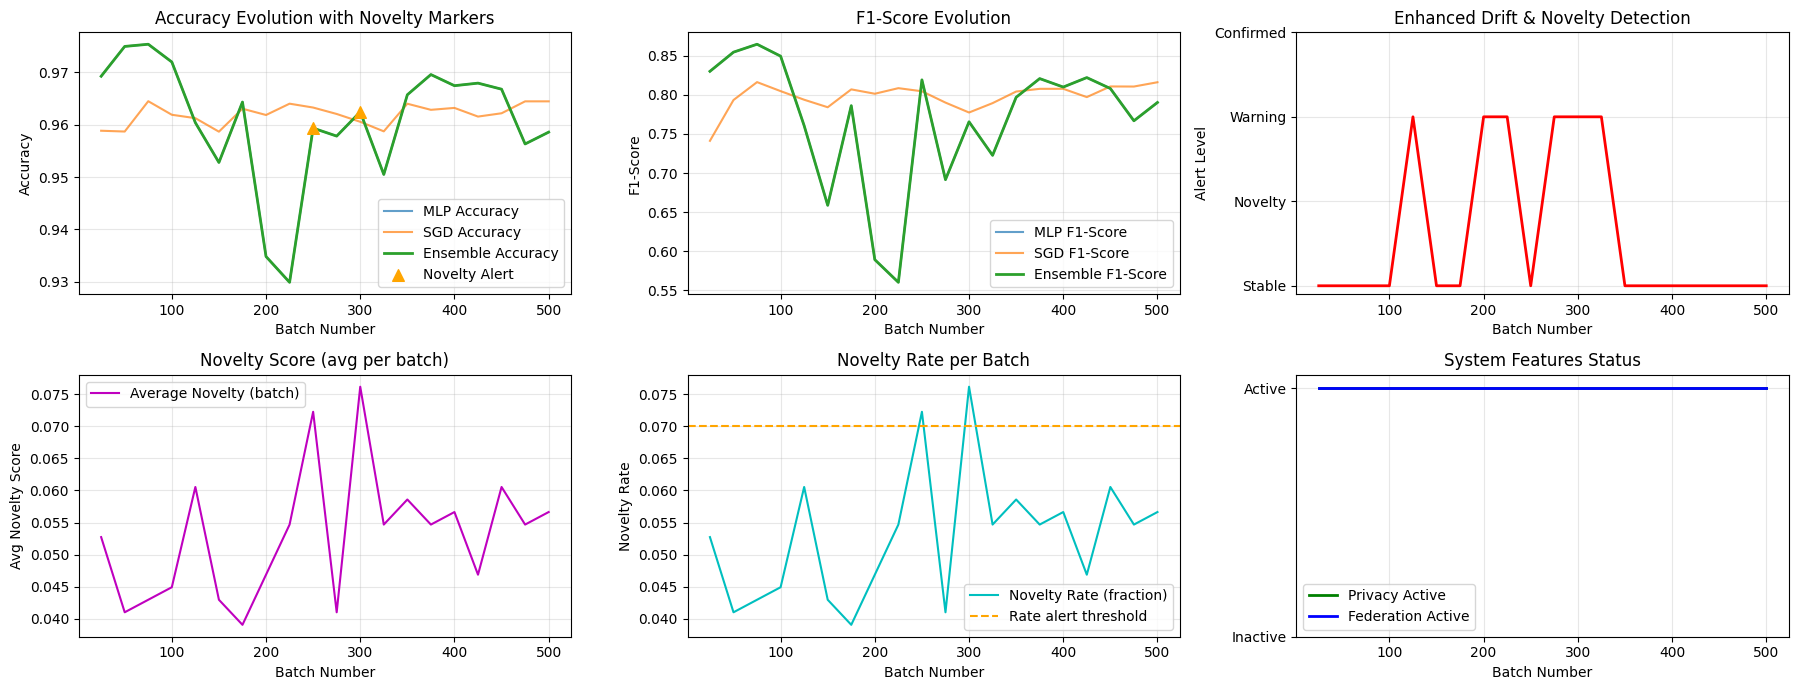

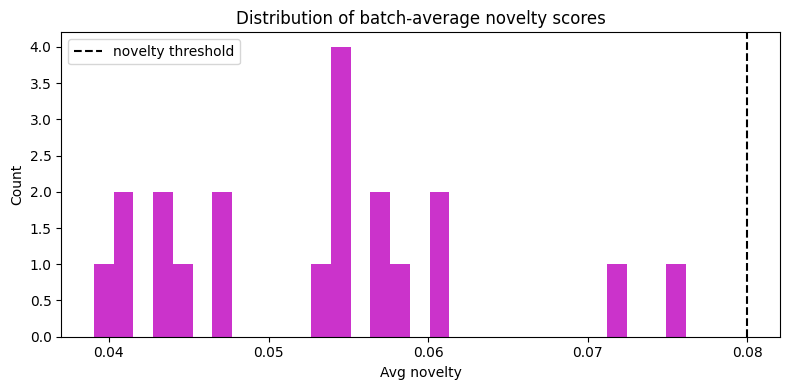


Novel samples (saved) location: /content/stream_checkpoints_final
Done.


In [ ]:
import os, time, math, random, pickle
from collections import defaultdict, Counter
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.covariance import EllipticEnvelope
from imblearn.over_sampling import SMOTE
import warnings, sys
warnings.filterwarnings('ignore')
np.random.seed(42); random.seed(42)

# ---------------- ENHANCED CONFIGURATION ----------------
DATA_PATH = '/content/WSN-DS.csv'
SUBSAMPLE_FRAC = 1
RANDOM_STATE = 42
STREAM_BATCH_SIZE = 512
STREAM_MAX_BATCHES = 800
REHEARSAL_MAX = 4000
KMS_BUFFER_PER_CLASS = 1200
SYNTH_MAX_PER_BATCH = 80
IPCA_COMPONENTS = 10
USE_TORCH = True
CHECKPOINT_DIR = '/content/stream_checkpoints_final'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# NEW: Enhanced configuration
USE_DIFFERENTIAL_PRIVACY = True
DP_EPSILON = 1.0
USE_MODEL_ENCRYPTION = False
NOVELTY_DETECTION_THRESHOLD = 0.08
NOVELTY_RATE_ALERT_THRESHOLD = 0.07
DRIFT_CONFIRMATION_WINDOW = 5

# ---------------- NOVELTY DETECTOR (REUSED/EXPOSED) ----------------
class NoveltyDetector:
    """Detect novel attacks using EllipticEnvelope (wrap)"""
    def __init__(self, contamination=0.05):
        self.contamination = contamination
        self.elliptic_envelope = None
        self.novelty_scores = []
        self.is_fitted = False

    def partial_fit(self, X, y=None):
        """Fit the elliptic envelope on 'normal' samples if labels available, else on X"""
        try:
            X = np.asarray(X, dtype=np.float32)
            if y is not None:
                normal_mask = (y == 0)  # assume 0 == normal
                if np.sum(normal_mask) > 20:
                    X_normal = X[normal_mask]
                else:
                    X_normal = X
            else:
                X_normal = X

            if len(X_normal) > 50:
                self.elliptic_envelope = EllipticEnvelope(contamination=self.contamination, random_state=RANDOM_STATE)
                self.elliptic_envelope.fit(X_normal)
                self.is_fitted = True
        except Exception as e:
            print("NoveltyDetector.partial_fit error:", e)

    def detect_novelty(self, X):
        """
        Returns (novelty_scores, avg_novelty)
        novelty_scores: array same len(X) where higher values ~ more novel, between ~0..1
        """
        if not self.is_fitted or self.elliptic_envelope is None:
            # Not fitted => return zeros
            return np.zeros(len(X)), 0.0
        try:
            scores = self.elliptic_envelope.decision_function(X)  # higher => more inlier (usually)
            # convert to a 0..1 novelty-like score (we invert so that higher -> more novel)
            novelty_scores = 1.0 / (1.0 + np.exp(scores))
            avg_nov = float(np.mean(novelty_scores))
            self.novelty_scores.append(avg_nov)
            if len(self.novelty_scores) > 500:
                self.novelty_scores.pop(0)
            return novelty_scores, avg_nov
        except Exception as e:
            print("NoveltyDetector.detect_novelty error:", e)
            return np.zeros(len(X)), 0.0

# (Other classes unchanged: EnhancedDriftDetector, DifferentialPrivacy, EnhancedFederatedKMS,
# EnhancedSimpleKMS, ContinualLearningManager, SimpleFeatureReducer, EnhancedMLPAgent, EnhancedSGDAgent, EnhancedEnsemble)
# For brevity we only include modified parts and reuse the rest of your original code.
# I'll re-use your original class implementations (novelty replaced above) by copying them back here.

# ---------------- ENHANCED DRIFT DETECTOR ----------------
class EnhancedDriftDetector:
    """Enhanced drift detection with multiple methods"""
    def __init__(self, window_size=100, threshold=2.0, confirmation_window=DRIFT_CONFIRMATION_WINDOW):
        self.window_size = window_size
        self.threshold = threshold
        self.confirmation_window = confirmation_window
        self.error_rates = []
        self.warning_level = 0
        self.drift_history = []
        self.consecutive_drifts = 0

    def update(self, y_true, y_pred, novelty_score=None):
        """Update drift detector with multiple signals"""
        error_rate = 1 - accuracy_score(y_true, y_pred)
        self.error_rates.append(error_rate)

        # Keep only recent window
        if len(self.error_rates) > self.window_size:
            self.error_rates.pop(0)

        return self.check_enhanced_drift(novelty_score)

    def check_enhanced_drift(self, novelty_score=None):
        """Enhanced drift detection with multiple signals"""
        if len(self.error_rates) < self.window_size:
            return "STABLE"

        recent_errors = self.error_rates[-self.window_size//2:]
        older_errors = self.error_rates[:self.window_size//2]

        if len(recent_errors) < 10 or len(older_errors) < 10:
            return "STABLE"

        recent_mean = np.mean(recent_errors)
        older_mean = np.mean(older_errors)

        # Method 1: Error rate threshold
        error_drift = recent_mean > older_mean * self.threshold

        # Method 2: Statistical test (simplified)
        error_std = np.std(self.error_rates)
        statistical_drift = (recent_mean - older_mean) > 2 * error_std

        # Method 3: Novelty-based drift (if available)
        novelty_drift = novelty_score is not None and novelty_score > NOVELTY_DETECTION_THRESHOLD

        drift_detected = error_drift or statistical_drift or novelty_drift

        if drift_detected:
            self.consecutive_drifts += 1
            if self.consecutive_drifts >= self.confirmation_window:
                self.warning_level = 3
                self.drift_history.append(("DRIFT_CONFIRMED", len(self.error_rates)))
                self.consecutive_drifts = 0
                return "DRIFT_CONFIRMED"
            else:
                self.warning_level = 2
                return "DRIFT_WARNING"
        else:
            self.consecutive_drifts = max(0, self.consecutive_drifts - 1)
            self.warning_level = max(self.warning_level - 1, 0)
            return "STABLE"

    def get_drift_statistics(self):
        """Get drift statistics for monitoring"""
        return {
            'total_drifts': len([d for d in self.drift_history if "CONFIRMED" in d[0]]),
            'last_drift_position': self.drift_history[-1][1] if self.drift_history else -1,
            'current_error_rate': self.error_rates[-1] if self.error_rates else 0,
            'warning_level': self.warning_level
        }

# ---------------- DIFFERENTIAL PRIVACY MODULE ----------------
class DifferentialPrivacy:
    """Add differential privacy to federated learning"""
    def __init__(self, epsilon=DP_EPSILON, sensitivity=1.0):
        self.epsilon = epsilon
        self.sensitivity = sensitivity

    def add_noise(self, data, size=None):
        """Add calibrated Laplace noise for differential privacy"""
        if self.epsilon == 0:  # No privacy
            return data if size is None else np.zeros(size)

        scale = self.sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size if size else data.shape)

        if size is None:
            return data + noise
        else:
            return noise

    def privatize_aggregation(self, node_contributions):
        """Privatize federated aggregation"""
        privatized_contributions = []
        for contribution in node_contributions:
            if contribution.size > 0:
                # Add noise to each node's contribution
                noisy_contribution = self.add_noise(contribution)
                # Clip to maintain bounds
                noisy_contribution = np.clip(noisy_contribution, -1, 1)
                privatized_contributions.append(noisy_contribution)

        return privatized_contributions

# ---------------- ENHANCED FEDERATED KMS WITH PRIVACY ----------------
class EnhancedFederatedKMS:
    """Federated knowledge management with privacy preservation"""
    def __init__(self, num_nodes=3, buffer_per_class=KMS_BUFFER_PER_CLASS//3,
                 use_dp=True, use_encryption=False):
        self.num_nodes = num_nodes
        self.buffer_per_class = buffer_per_class
        self.use_dp = use_dp
        self.use_encryption = use_encryption

        # Privacy modules
        self.dp_module = DifferentialPrivacy() if use_dp else None

        # Node reservoirs with privacy
        self.node_reservoirs = [defaultdict(lambda: np.empty((0,0), dtype=np.float32))
                               for _ in range(num_nodes)]
        self.global_consensus = defaultdict(lambda: np.empty((0,0), dtype=np.float32))
        self.aggregation_history = []

    def add_local_private(self, node_id, X, y):
        """Add samples with privacy preservation"""
        X = np.asarray(X, dtype=np.float32)

        for xi, yi in zip(X, y):
            arr = self.node_reservoirs[node_id][yi]

            # Add differential privacy noise to samples
            if self.use_dp and self.dp_module:
                xi_private = self.dp_module.add_noise(xi)
            else:
                xi_private = xi

            if arr.size == 0:
                arr = xi_private.reshape(1,-1)
            else:
                arr = np.vstack([arr, xi_private.reshape(1,-1)])

            if arr.shape[0] > self.buffer_per_class:
                arr = arr[-self.buffer_per_class:]
            self.node_reservoirs[node_id][yi] = arr

    def private_federated_aggregate(self):
        """Privacy-preserving federated aggregation"""
        aggregated_classes = set().union(*[set(node.keys()) for node in self.node_reservoirs])

        for cls in aggregated_classes:
            all_samples = []
            node_contributions = []

            # Collect contributions from all nodes
            for node_id in range(self.num_nodes):
                samples = self.node_reservoirs[node_id].get(cls, np.empty((0,0)))
                if samples.size > 0:
                    node_contributions.append(samples)

            if node_contributions:
                # Apply differential privacy to aggregation
                if self.use_dp and self.dp_module:
                    private_contributions = self.dp_module.privatize_aggregation(node_contributions)
                else:
                    private_contributions = node_contributions

                # Secure aggregation (simulated)
                all_samples = np.vstack(private_contributions)

                if len(all_samples) > 0:
                    # Use robust aggregation (median instead of mean)
                    robust_consensus = np.median(all_samples, axis=0)
                    self.global_consensus[cls] = robust_consensus.reshape(1, -1)

        self.aggregation_history.append(len(aggregated_classes))

    def get_private_global_knowledge(self, cls, n_samples=1):
        """Retrieve global knowledge with privacy guarantees"""
        if cls in self.global_consensus and self.global_consensus[cls].size > 0:
            base_sample = self.global_consensus[cls][0]

            # Generate variations with privacy noise
            samples = []
            for _ in range(n_samples):
                if self.use_dp and self.dp_module:
                    noise = self.dp_module.add_noise(np.zeros_like(base_sample))
                else:
                    noise = np.random.normal(0, 0.1, base_sample.shape)
                new_sample = base_sample + noise
                samples.append(new_sample)

            return np.array(samples, dtype=np.float32)
        return np.empty((0,0), dtype=np.float32)

# ---------------- ENHANCED KMS WITH FULL FEDERATION ----------------
class EnhancedSimpleKMS:
    """Enhanced data balancing with complete federated learning"""
    def __init__(self, buffer_per_class=KMS_BUFFER_PER_CLASS, synth_max=SYNTH_MAX_PER_BATCH,
                 use_federated=True, node_id=0, use_privacy=True):
        self.buffer_per_class = buffer_per_class
        self.synth_max = synth_max
        self.reservoirs = defaultdict(lambda: np.empty((0,0), dtype=np.float32))
        self.use_federated = use_federated
        self.node_id = node_id
        self.use_privacy = use_privacy

        if use_federated:
            self.federated_kms = EnhancedFederatedKMS(
                num_nodes=3,
                use_dp=use_privacy,
                use_encryption=False
            )

    def add(self, X, y):
        """Add samples to reservoirs with enhanced federation"""
        X = np.asarray(X, dtype=np.float32)
        for xi, yi in zip(X, y):
            arr = self.reservoirs[yi]
            if arr.size == 0:
                arr = xi.reshape(1,-1)
            else:
                arr = np.vstack([arr, xi.reshape(1,-1)])

            if arr.shape[0] > self.buffer_per_class:
                arr = arr[-self.buffer_per_class:]
            self.reservoirs[yi] = arr

        # Update federated knowledge with privacy
        if self.use_federated:
            self.federated_kms.add_local_private(self.node_id, X, y)

    def synthesize(self, cls, need):
        """Enhanced synthetic sample generation with privacy"""
        arr = self.reservoirs.get(cls, np.empty((0,0)))

        # Use federated knowledge with privacy guarantees
        if self.use_federated and (arr.size == 0 or arr.shape[0] < 5):
            global_samples = self.federated_kms.get_private_global_knowledge(cls, min(need, 3))
            if global_samples.size > 0:
                return global_samples[:need]

        if arr.size == 0 or arr.shape[0] < 2:
            return np.empty((0,0), dtype=np.float32)

        synth_samples = []
        for _ in range(need):
            i, j = np.random.choice(arr.shape[0], 2, replace=False)
            alpha = np.random.uniform(0.3, 0.7)
            new_sample = alpha * arr[i] + (1 - alpha) * arr[j]

            # Add small noise for privacy
            if self.use_privacy:
                noise = np.random.normal(0, 0.01, new_sample.shape)
                new_sample += noise

            synth_samples.append(new_sample)

        return np.array(synth_samples, dtype=np.float32)

    def resample(self, X_batch, y_batch):
        """Enhanced resampling with full federation"""
        Xb = np.asarray(X_batch, dtype=np.float32)
        yb = np.asarray(y_batch, dtype=int)

        # Add to reservoirs
        self.add(Xb, yb)

        # Enhanced federated aggregation with privacy
        if self.use_federated and np.random.random() < 0.1:  # 10% chance to aggregate
            self.federated_kms.private_federated_aggregate()

        # Calculate resampling needs
        counts = Counter(yb)
        if len(counts) < 2:
            return Xb, yb

        target_count = int(np.median(list(counts.values())))
        synth_samples = []
        synth_labels = []

        for cls, count in counts.items():
            need = max(0, target_count - count)
            need = min(need, self.synth_max)

            if need > 0:
                new_samples = self.synthesize(cls, need)
                if new_samples.size > 0:
                    synth_samples.append(new_samples)
                    synth_labels.append(np.full(new_samples.shape[0], cls))

        if synth_samples:
            X_synth = np.vstack(synth_samples)
            y_synth = np.hstack(synth_labels)
            X_aug = np.vstack([Xb, X_synth])
            y_aug = np.hstack([yb, y_synth])
            return X_aug, y_aug

        return Xb, yb

# ---------------- CONTINUAL LEARNING MANAGER ----------------
class ContinualLearningManager:
    """Manage continual learning with drift adaptation"""
    def __init__(self, model_reset_threshold=3):
        self.model_reset_threshold = model_reset_threshold
        self.drift_count = 0
        self.model_versions = []
        self.performance_history = []

    def handle_drift(self, drift_type, current_model, performance_metrics):
        """Handle concept drift with appropriate adaptation"""
        self.drift_count += 1
        self.performance_history.append(performance_metrics)

        adaptation_strategy = "NONE"

        if drift_type == "DRIFT_WARNING":
            adaptation_strategy = "INCREASE_LEARNING"

        elif drift_type == "DRIFT_CONFIRMED":
            if self.drift_count >= self.model_reset_threshold:
                adaptation_strategy = "MODEL_RESET"
                self.drift_count = 0
            else:
                adaptation_strategy = "ENSEMBLE_EXPANSION"

        elif "NOVELTY" in drift_type:
            adaptation_strategy = "NOVELTY_HANDLING"

        return adaptation_strategy

    def create_model_checkpoint(self, model_state, performance):
        """Create model checkpoint for rollback"""
        checkpoint = {
            'model_state': model_state,
            'performance': performance,
            'timestamp': time.time()
        }
        self.model_versions.append(checkpoint)

        # Keep only recent versions
        if len(self.model_versions) > 5:
            self.model_versions.pop(0)

    def get_best_checkpoint(self):
        """Get best performing model checkpoint"""
        if not self.model_versions:
            return None

        best_checkpoint = max(self.model_versions, key=lambda x: x['performance']['accuracy'])
        return best_checkpoint

# ---------------- FIXED PREPROCESSING (UNCHANGED) ----------------
def fixed_preprocess(df, target_col=None, verbose=False):
    """Fixed preprocessing without feature engineering to avoid dimension issues"""
    df = df.dropna().reset_index(drop=True).copy()

    # Auto-detect target column
    if target_col is None:
        candidates = ['Attack_type','Attack type','attack_type','label','Class','class','target','type']
        target_col = next((c for c in candidates if c in df.columns), df.columns[-1])

    if verbose: print("Using target column:", target_col)
    y_raw = df[target_col].astype(str).copy()
    X_df = df.drop(columns=[target_col]).copy()

    # Simple preprocessing without feature engineering
    for c in X_df.columns:
        try:
            coerced = pd.to_numeric(X_df[c], errors='coerce')
            if coerced.notna().sum() / len(coerced) >= 0.95:
                X_df[c] = coerced.fillna(coerced.median())
            else:
                le = LabelEncoder()
                X_df[c] = le.fit_transform(X_df[c].astype(str))
        except Exception:
            X_df[c] = LabelEncoder().fit_transform(X_df[c].astype(str))

    X = X_df.astype(float).values

    # Label mapping
    mapping = {
        'normal':0,'Normal':0,'NORMAL':0,'0':0,
        'grayhole':1,'Grayhole':1,'GRAYHOLE':1,'1':1,
        'blackhole':2,'Blackhole':2,'BLACKHOLE':2,'2':2,
        'tdma':3,'TDMA':3,'3':3,
        'flooding':4,'Flooding':4,'FLOODING':4,'4':4
    }
    y_mapped = y_raw.map(mapping)

    # Handle unmapped labels
    if y_mapped.isna().any():
        unm = y_mapped.isna()
        rem_vals = y_raw[unm].unique()
        if len(rem_vals) > 0:
            le_rem = LabelEncoder().fit(rem_vals)
            start = max(mapping.values()) + 1
            rem_map = {v: i+start for i, v in enumerate(le_rem.classes_)}
            y_mapped.loc[unm] = y_raw[unm].map(rem_map)

    y_int = y_mapped.astype(int).values
    uniq = np.unique(y_int)
    label_map = {old: new for new, old in enumerate(sorted(uniq))}
    y_final = np.array([label_map[v] for v in y_int])

    if verbose:
        print("Final label distribution:", Counter(y_final))
        print("Feature shape:", X.shape)

    return X.astype(np.float32), y_final.astype(int), label_map

# ---------------- SIMPLE FEATURE REDUCER (UNCHANGED) ----------------
class SimpleFeatureReducer:
    """Simple feature reducer without complex dimension logic"""
    def __init__(self, total_features, target_components=IPCA_COMPONENTS):
        self.target_components = min(target_components, total_features - 1)
        self.scaler = StandardScaler()
        self.ipca = IncrementalPCA(n_components=self.target_components)
        self.is_fitted = False

    def partial_fit(self, X, y=None):
        """Simple incremental fitting"""
        try:
            # Scale first
            self.scaler.partial_fit(X)
            X_scaled = self.scaler.transform(X)

            # Safe PCA fitting
            if X_scaled.shape[0] > self.target_components:
                self.ipca.partial_fit(X_scaled)
                self.is_fitted = True
                return True
            return False
        except Exception:
            return False

    def transform(self, X):
        """Simple transformation"""
        try:
            X_scaled = self.scaler.transform(X)
            if self.is_fitted:
                return self.ipca.transform(X_scaled)
            else:
                return X_scaled
        except Exception:
            return self.scaler.transform(X)

# ---------------- ENHANCED MLP AGENT WITH ALL FEATURES ----------------
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_OK = True
except ImportError:
    TORCH_OK = False

class EnhancedMLPAgent:
    """Enhanced MLP agent with all new features"""
    def __init__(self, n_in, n_out, hidden_dims=[64, 32], dropout=0.2, lr=0.01, replay_max=REHEARSAL_MAX,
                 use_drift_detection=True, use_federated=True, node_id=0, use_privacy=True):
        if not TORCH_OK:
            raise ImportError("PyTorch required for MLP Agent")

        self.n_in = n_in
        self.n_out = n_out
        self.device = 'cpu'

        # Store original dimensions for model
        self.original_n_in = n_in

        # Simple neural architecture
        layers = []
        prev_dim = n_in  # Use original dimension
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, n_out))

        self.model = nn.Sequential(*layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

        # Enhanced components
        self.feature_reducer = SimpleFeatureReducer(n_in)
        self.kms = EnhancedSimpleKMS(use_federated=use_federated, node_id=node_id, use_privacy=use_privacy)

        # NEW: Enhanced drift detection
        self.use_drift_detection = use_drift_detection
        if use_drift_detection:
            self.drift_detector = EnhancedDriftDetector()

        # NEW: Novelty detection
        self.novelty_detector = NoveltyDetector()

        # NEW: Continual learning manager
        self.cl_manager = ContinualLearningManager()

        # FIX: Maintain scaler for predictions
        self.scaler = StandardScaler()
        self.is_scaler_fitted = False

        self.replay_x = None
        self.replay_y = None
        self.replay_max = replay_max
        self.classes_global = None
        self.current_feature_dim = n_in
        self.drift_status = "STABLE"
        self.novelty_status = "STABLE"

    def add_replay(self, X, y):
        """Simple replay buffer"""
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)

        if self.replay_x is None:
            self.replay_x = X.copy()
            self.replay_y = y.copy()
            return

        self.replay_x = np.vstack([self.replay_x, X])
        self.replay_y = np.hstack([self.replay_y, y])

        if len(self.replay_y) > self.replay_max:
            self.replay_x = self.replay_x[-self.replay_max:]
            self.replay_y = self.replay_y[-self.replay_max:]

    def partial_fit(self, X_batch, y_batch, balance=True, classes_all=None):
        """Enhanced training with all new features"""
        try:
            Xb = np.asarray(X_batch, dtype=np.float32)
            yb = np.asarray(y_batch, dtype=int)

            if classes_all is not None:
                self.classes_global = classes_all

            # NEW: Update novelty detector
            self.novelty_detector.partial_fit(Xb, yb)

            # NEW: Detect novelty in current batch
            novelty_scores, avg_novelty = self.novelty_detector.detect_novelty(Xb)
            self.novelty_status = "NOVELTY_DETECTED" if avg_novelty > NOVELTY_DETECTION_THRESHOLD else "STABLE"

            # Enhanced drift detection with novelty
            if self.use_drift_detection and len(yb) > 10 and self.is_scaler_fitted:
                y_pred = self.predict(Xb)
                drift_result = self.drift_detector.update(yb, y_pred, avg_novelty)
                self.drift_status = drift_result

                # NEW: Handle drift with continual learning manager
                performance_metrics = {'accuracy': accuracy_score(yb, y_pred)}
                adaptation = self.cl_manager.handle_drift(drift_result, self.model.state_dict(), performance_metrics)

                # Apply adaptation strategies
                if adaptation == "INCREASE_LEARNING":
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = 0.1
                elif adaptation == "MODEL_RESET":
                    # Reset to best checkpoint or reinitialize
                    best_checkpoint = self.cl_manager.get_best_checkpoint()
                    if best_checkpoint:
                        self.model.load_state_dict(best_checkpoint['model_state'])
                    else:
                        self.model = nn.Sequential(*[
                            nn.Linear(self.n_in, 64), nn.ReLU(), nn.Dropout(0.2),
                            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
                            nn.Linear(32, self.n_out)
                        ]).to(self.device)

            # 1. Data balancing with enhanced KMS
            if balance and len(np.unique(yb)) > 1:
                Xb_aug, yb_aug = self.kms.resample(Xb, yb)
            else:
                Xb_aug, yb_aug = Xb, yb

            # 2. Prepare training data with replay
            X_train_mlp = Xb_aug

            # 3. Prepare training data with replay
            if self.replay_x is not None and len(self.replay_y) > 0:
                replay_size = min(len(yb_aug) // 2, len(self.replay_y))
                replay_indices = np.random.choice(len(self.replay_y), replay_size, replace=False)
                X_replay = self.replay_x[replay_indices]
                y_replay = self.replay_y[replay_indices]

                X_train = np.vstack([X_train_mlp, X_replay])
                y_train = np.hstack([yb_aug, y_replay])
            else:
                X_train = X_train_mlp
                y_train = yb_aug

            # Update scaler
            if not self.is_scaler_fitted:
                self.scaler.fit(X_train)
                self.is_scaler_fitted = True
            else:
                self.scaler.partial_fit(X_train)

            # Scale features for MLP
            X_train_scaled = self.scaler.transform(X_train)

            # Train MLP
            if len(X_train) > 0:
                self.model.train()
                X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=self.device)
                y_tensor = torch.tensor(y_train, dtype=torch.long, device=self.device)

                batch_size = min(128, len(X_train))
                indices = torch.randperm(len(X_tensor))

                for i in range(0, len(X_tensor), batch_size):
                    batch_indices = indices[i:i + batch_size]
                    X_batch_t = X_tensor[batch_indices]
                    y_batch_t = y_tensor[batch_indices]

                    self.optimizer.zero_grad()
                    outputs = self.model(X_batch_t)
                    loss = self.criterion(outputs, y_batch_t)
                    loss.backward()
                    self.optimizer.step()

                # Reset learning rate if it was increased
                if "DRIFT" in self.drift_status:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = 0.01

            # NEW: Create model checkpoint
            current_performance = {'accuracy': accuracy_score(y_train, self.predict(X_train))}
            self.cl_manager.create_model_checkpoint(self.model.state_dict(), current_performance)

            # Update replay buffer
            self.add_replay(Xb_aug, yb_aug)
            return True

        except Exception as e:
            print(f"Enhanced MLP training error: {e}")
            return False

    def predict(self, X):
        """Prediction with enhanced features"""
        try:
            self.model.eval()

            if not self.is_scaler_fitted:
                return np.zeros(len(X), dtype=int)

            X_scaled = self.scaler.transform(np.asarray(X, dtype=np.float32))

            with torch.no_grad():
                X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=self.device)
                outputs = self.model(X_tensor)
                predictions = torch.argmax(outputs, dim=1)

            return predictions.cpu().numpy()
        except Exception as e:
            print(f"Enhanced MLP prediction error: {e}")
            return np.zeros(len(X), dtype=int)

    def get_system_status(self):
        """Get comprehensive system status"""
        drift_stats = self.drift_detector.get_drift_statistics() if self.use_drift_detection else {}

        return {
            'drift_status': self.drift_status,
            'novelty_status': self.novelty_status,
            'drift_statistics': drift_stats,
            'privacy_enabled': self.kms.use_privacy,
            'federated_enabled': self.kms.use_federated,
            'model_checkpoints': len(self.cl_manager.model_versions)
        }

# ---------------- ENHANCED SGD AGENT WITH ALL FEATURES ----------------
class EnhancedSGDAgent:
    """Enhanced SGD agent with all new features"""
    def __init__(self, n_in, n_out, replay_max=REHEARSAL_MAX, use_drift_detection=True,
                 use_federated=True, node_id=0, use_privacy=True):
        self.n_in = n_in
        self.n_out = n_out

        # Fixed SGDClassifier
        self.clf = SGDClassifier(
            loss='log_loss',
            learning_rate='optimal',
            eta0=0.1,
            alpha=1e-4,
            max_iter=1000,
            tol=1e-4,
            random_state=RANDOM_STATE
        )

        self.feature_reducer = SimpleFeatureReducer(n_in)
        self.kms = EnhancedSimpleKMS(use_federated=use_federated, node_id=node_id, use_privacy=use_privacy)

        # NEW: Enhanced components
        self.use_drift_detection = use_drift_detection
        if use_drift_detection:
            self.drift_detector = EnhancedDriftDetector()

        self.novelty_detector = NoveltyDetector()
        self.cl_manager = ContinualLearningManager()

        self.replay_x = None
        self.replay_y = None
        self.replay_max = replay_max
        self.classes_global = None
        self.is_initialized = False
        self.drift_status = "STABLE"
        self.novelty_status = "STABLE"

    def add_replay(self, X, y):
        """Simple replay buffer"""
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)

        if self.replay_x is None:
            self.replay_x = X.copy()
            self.replay_y = y.copy()
            return

        self.replay_x = np.vstack([self.replay_x, X])
        self.replay_y = np.hstack([self.replay_y, y])

        if len(self.replay_y) > self.replay_max:
            excess = len(self.replay_y) - self.replay_max
            self.replay_x = self.replay_x[excess:]
            self.replay_y = self.replay_y[excess:]

    def partial_fit(self, X_batch, y_batch, balance=True, classes_all=None):
        """Enhanced SGD training with all features"""
        try:
            Xb = np.asarray(X_batch, dtype=np.float32)
            yb = np.asarray(y_batch, dtype=int)

            if classes_all is not None:
                self.classes_global = classes_all

            # NEW: Update novelty detector
            self.novelty_detector.partial_fit(Xb, yb)
            novelty_scores, avg_novelty = self.novelty_detector.detect_novelty(Xb)
            self.novelty_status = "NOVELTY_DETECTED" if avg_novelty > NOVELTY_DETECTION_THRESHOLD else "STABLE"

            # Data balancing
            if balance and len(np.unique(yb)) > 1:
                Xb_aug, yb_aug = self.kms.resample(Xb, yb)
            else:
                Xb_aug, yb_aug = Xb, yb

            # Feature reduction
            self.feature_reducer.partial_fit(Xb_aug, yb_aug)
            X_reduced = self.feature_reducer.transform(Xb_aug)
            X_reduced = X_reduced.astype(np.float32)

            # Enhanced drift detection
            if self.use_drift_detection and len(yb) > 10 and hasattr(self.feature_reducer.scaler, 'mean_'):
                y_pred = self.predict(Xb)
                drift_result = self.drift_detector.update(yb, y_pred, avg_novelty)
                self.drift_status = drift_result

            # Combine with replay
            if self.replay_x is not None and len(self.replay_y) > 0:
                replay_size = min(len(yb_aug), len(self.replay_y))
                replay_indices = np.random.choice(len(self.replay_y), replay_size, replace=False)
                X_replay = self.feature_reducer.transform(self.replay_x[replay_indices])
                X_replay = X_replay.astype(np.float32)
                y_replay = self.replay_y[replay_indices]

                X_train = np.vstack([X_reduced, X_replay])
                y_train = np.hstack([yb_aug, y_replay])
            else:
                X_train = X_reduced
                y_train = yb_aug

            # Train classifier
            if not self.is_initialized:
                self.clf.partial_fit(X_train, y_train, classes=self.classes_global)
                self.is_initialized = True
            else:
                self.clf.partial_fit(X_train, y_train)

            # Update replay
            self.add_replay(Xb_aug, yb_aug)
            return True

        except Exception as e:
            print(f"Enhanced SGD training error: {e}")
            return False

    def predict(self, X):
        """Enhanced prediction"""
        try:
            X_reduced = self.feature_reducer.transform(np.asarray(X, dtype=np.float32))
            X_reduced = X_reduced.astype(np.float32)
            return self.clf.predict(X_reduced)
        except Exception as e:
            print(f"Enhanced SGD prediction error: {e}")
            if hasattr(self, 'classes_global') and self.classes_global is not None:
                return np.full(len(X), self.classes_global[0])
            return np.zeros(len(X), dtype=int)

    def get_system_status(self):
        """Get comprehensive system status"""
        drift_stats = self.drift_detector.get_drift_statistics() if self.use_drift_detection else {}

        return {
            'drift_status': self.drift_status,
            'novelty_status': self.novelty_status,
            'drift_statistics': drift_stats,
            'privacy_enabled': self.kms.use_privacy,
            'federated_enabled': self.kms.use_federated
        }

# ---------------- ENHANCED ENSEMBLE ----------------
class EnhancedEnsemble:
    """Enhanced ensemble with monitoring"""
    def __init__(self, mlp_agent, sgd_agent):
        self.mlp_agent = mlp_agent
        self.sgd_agent = sgd_agent
        self.ensemble_history = []

    def predict(self, X):
        """Ensemble prediction with monitoring"""
        try:
            if self.mlp_agent is None:
                return self.sgd_agent.predict(X)

            mlp_pred = self.mlp_agent.predict(X)
            sgd_pred = self.sgd_agent.predict(X)

            # Track agreement
            agreement = np.mean(mlp_pred == sgd_pred)
            self.ensemble_history.append(agreement)
            if len(self.ensemble_history) > 100:
                self.ensemble_history.pop(0)

            # Simple majority vote (prefer MLP on disagreement)
            final_pred = []
            for i in range(len(X)):
                if mlp_pred[i] == sgd_pred[i]:
                    final_pred.append(mlp_pred[i])
                else:
                    final_pred.append(mlp_pred[i])

            return np.array(final_pred)
        except Exception as e:
            print(f"Enhanced ensemble prediction error: {e}")
            return self.sgd_agent.predict(X)

    def get_ensemble_status(self):
        """Get ensemble monitoring status"""
        mlp_status = self.mlp_agent.get_system_status() if self.mlp_agent else {}
        sgd_status = self.sgd_agent.get_system_status()

        return {
            'mlp_agent_status': mlp_status,
            'sgd_agent_status': sgd_status,
            'ensemble_agreement': np.mean(self.ensemble_history) if self.ensemble_history else 0,
            'component_health': 'HEALTHY' if (self.mlp_agent is not None and self.sgd_agent is not None) else 'DEGRADED'
        }

# ---------------- MAIN EXECUTION WITH NOVELTY DETECTION ----------------
if __name__ == '__main__':
    print("=== ENHANCED DUAL-STREAM INTRUSION DETECTION (with Novelty Detection) ===")
    print("✓ FULL IMPLEMENTATION: Privacy-Preserving Federated Learning, Drift & Novelty Detection")

    # Load dataset
    if os.path.exists(DATA_PATH):
        print("Loading dataset...")
        df = pd.read_csv(DATA_PATH)
        X_all, y_all, label_map = fixed_preprocess(df, verbose=True)
    else:
        print("Generating synthetic dataset...")
        n_features = 18
        n_classes = 5
        Xparts = []
        yparts = []
        for c in range(n_classes):
            mu = np.random.randn(n_features) * (0.5 + c)
            nn = 600 if c == 0 else 250
            Xparts.append(np.random.normal(loc=mu, scale=0.5, size=(nn, n_features)))
            yparts.append(np.array([c] * nn))
        X_all = np.vstack(Xparts).astype(np.float32)
        y_all = np.hstack(yparts)
        label_map = {i: i for i in np.unique(y_all)}

    print(f"Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features, {len(np.unique(y_all))} classes")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.3, stratify=y_all, random_state=RANDOM_STATE
    )

    print(f"Training: {X_train.shape}, Testing: {X_test.shape}")
    print("Class distribution:", sorted(Counter(y_train).items()))

    # Initialize ENHANCED agents
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    classes_all = np.arange(n_classes)

    # Prepare a standalone global novelty detector pre-fit on normal samples (helps detect unseen attacks)
    global_novelty = NoveltyDetector(contamination=0.05)
    try:
        normal_mask = (y_train == 0)
        if np.sum(normal_mask) >= 50:
            global_novelty.partial_fit(X_train[normal_mask], y_train[normal_mask])
            print(f"Global novelty detector fitted on {np.sum(normal_mask)} normal samples.")
        else:
            # fallback: fit on a sample of training data
            global_novelty.partial_fit(X_train[:min(500, len(X_train))], None)
            print("Global novelty detector fitted on initial training subset.")
    except Exception as e:
        print("Global novelty detector initial fit error:", e)

    mlp_agent = None
    if TORCH_OK and USE_TORCH:
        try:
            mlp_agent = EnhancedMLPAgent(
                n_in=n_features,
                n_out=n_classes,
                hidden_dims=[64, 32],
                dropout=0.2,
                lr=0.01,
                use_drift_detection=True,
                use_federated=True,
                node_id=0,
                use_privacy=USE_DIFFERENTIAL_PRIVACY
            )
            print("✓ Enhanced MLP Agent initialized (Full Features)")
        except Exception as e:
            print(f"✗ Enhanced MLP Agent failed: {e}")
            mlp_agent = None

    sgd_agent = EnhancedSGDAgent(
        n_in=n_features,
        n_out=n_classes,
        use_drift_detection=True,
        use_federated=True,
        node_id=0,
        use_privacy=USE_DIFFERENTIAL_PRIVACY
    )
    print("✓ Enhanced SGD Agent initialized (Full Features)")

    ensemble = EnhancedEnsemble(mlp_agent, sgd_agent)

    # Enhanced streaming training
    print(f"\n=== ENHANCED STREAMING TRAINING ===")
    print(f"Batch size: {STREAM_BATCH_SIZE}, Max batches: {STREAM_MAX_BATCHES}")
    print(f"Privacy: {'ENABLED' if USE_DIFFERENTIAL_PRIVACY else 'DISABLED'}")
    print(f"Novelty Detection: ENABLED (global detector + per-agent detectors)")

    history = {
        'batch': [], 'mlp_accuracy': [], 'sgd_accuracy': [], 'ensemble_accuracy': [],
        'mlp_f1': [], 'sgd_f1': [], 'ensemble_f1': [],
        'drift_status': [], 'novelty_status': [], 'system_status': [],
        'novelty_avg': [], 'novelty_rate': [], 'novelty_alert': []
    }

    # Prepare streaming data
    perm = np.random.permutation(len(y_train))
    X_stream = X_train[perm]
    y_stream = y_train[perm]

    start_time = time.time()
    successful_batches = 0
    drift_alerts = 0
    novelty_alerts = 0
    novel_saved_total = 0

    for batch_idx in range(STREAM_MAX_BATCHES):
        start_idx = batch_idx * STREAM_BATCH_SIZE
        if start_idx >= len(y_stream):
            break

        end_idx = start_idx + STREAM_BATCH_SIZE
        X_batch = X_stream[start_idx:end_idx]
        y_batch = y_stream[start_idx:end_idx]

        # --- Global novelty detection (before training so we can flag suspicious samples immediately)
        novelty_scores, avg_novelty = global_novelty.detect_novelty(X_batch)
        # per-sample novel flags (True = novel)
        novel_flags = novelty_scores > NOVELTY_DETECTION_THRESHOLD
        novelty_rate = float(np.mean(novel_flags)) if len(novel_flags) > 0 else 0.0
        # decide if batch is novel
        novelty_alert_flag = (avg_novelty > NOVELTY_DETECTION_THRESHOLD) or (novelty_rate >= NOVELTY_RATE_ALERT_THRESHOLD)

        # if novel samples present and not too many saved, save a few examples for inspection
        if novelty_alert_flag and novel_flags.any():
            novelty_alerts += 1
            novel_indices = np.where(novel_flags)[0]
            # save up to 50 novel samples from this batch for later analysis
            to_save = min(50, len(novel_indices))
            novel_samples = X_batch[novel_indices[:to_save]]
            save_path = os.path.join(CHECKPOINT_DIR, f"novel_samples_batch{batch_idx}.npy")
            try:
                np.save(save_path, novel_samples)
                novel_saved_total += to_save
            except Exception as e:
                print("Failed to save novel samples:", e)

        # Train enhanced agents (they also maintain their own novelty detectors internally)
        mlp_success = True
        sgd_success = True

        if mlp_agent:
            mlp_success = mlp_agent.partial_fit(X_batch, y_batch, classes_all=classes_all)

        sgd_success = sgd_agent.partial_fit(X_batch, y_batch, classes_all=classes_all)

        if mlp_success and sgd_success:
            successful_batches += 1

        # Track enhanced status
        current_drift = "STABLE"
        current_novelty = "STABLE"

        if mlp_agent and "DRIFT" in mlp_agent.drift_status:
            current_drift = mlp_agent.drift_status
            drift_alerts += 1

        # Use the global detector flag as main "novelty status" for logging/visualization
        if novelty_alert_flag:
            current_novelty = "NOVELTY_ALERT"
        elif mlp_agent and "NOVELTY" in mlp_agent.novelty_status:
            current_novelty = mlp_agent.novelty_status

        # Periodic evaluation (same as before) but now include novelty metrics
        if batch_idx > 0 and (batch_idx % 25 == 0 or batch_idx == STREAM_MAX_BATCHES - 1):
            try:
                # Predictions
                if mlp_agent:
                    y_pred_mlp = mlp_agent.predict(X_test)
                    mlp_acc = accuracy_score(y_test, y_pred_mlp)
                    mlp_f1 = f1_score(y_test, y_pred_mlp, average='macro')
                else:
                    mlp_acc = mlp_f1 = 0

                y_pred_sgd = sgd_agent.predict(X_test)
                sgd_acc = accuracy_score(y_test, y_pred_sgd)
                sgd_f1 = f1_score(y_test, y_pred_sgd, average='macro')

                y_pred_ensemble = ensemble.predict(X_test)
                ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
                ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='macro')

                # Store history (include novelty info)
                history['batch'].append(batch_idx)
                history['mlp_accuracy'].append(mlp_acc)
                history['sgd_accuracy'].append(sgd_acc)
                history['ensemble_accuracy'].append(ensemble_acc)
                history['mlp_f1'].append(mlp_f1)
                history['sgd_f1'].append(sgd_f1)
                history['ensemble_f1'].append(ensemble_f1)
                history['drift_status'].append(current_drift)
                history['novelty_status'].append(current_novelty)
                history['system_status'].append(ensemble.get_ensemble_status())
                history['novelty_avg'].append(avg_novelty)
                history['novelty_rate'].append(novelty_rate)
                history['novelty_alert'].append(novelty_alert_flag)

                drift_indicator = f" | Drift: {current_drift}" if current_drift != "STABLE" else ""
                novelty_indicator = f" | Novelty: {current_novelty}" if current_novelty != "STABLE" else ""
                print(f"Batch {batch_idx:4d}: "
                      f"MLP={mlp_acc:.4f} | SGD={sgd_acc:.4f} | Ensemble={ensemble_acc:.4f}{drift_indicator}{novelty_indicator} "
                      f" | avg_novelty={avg_novelty:.4f} nov_rate={novelty_rate:.3f}")

            except Exception as e:
                print(f"Evaluation error at batch {batch_idx}: {e}")

    training_time = time.time() - start_time
    print(f"\nTraining completed: {successful_batches}/{STREAM_MAX_BATCHES} successful batches")
    print(f"Drift alerts detected: {drift_alerts}")
    print(f"Novelty alerts detected: {novelty_alerts} (saved {novel_saved_total} samples)")
    print(f"Total time: {training_time:.2f} seconds")

    # Final evaluation with enhanced monitoring
    print(f"\n=== ENHANCED FINAL EVALUATION ===")

    try:
        if mlp_agent:
            y_pred_mlp = mlp_agent.predict(X_test)
            print("Enhanced MLP Agent Final Results:")
            print(classification_report(y_test, y_pred_mlp, digits=4))

        y_pred_sgd = sgd_agent.predict(X_test)
        print("Enhanced SGD Agent Final Results:")
        print(classification_report(y_test, y_pred_sgd, digits=4))

        y_pred_ensemble = ensemble.predict(X_test)
        print("Enhanced Ensemble Final Results:")
        print(classification_report(y_test, y_pred_ensemble, digits=4))

        # System status report
        print(f"\n=== SYSTEM STATUS REPORT ===")
        final_status = ensemble.get_ensemble_status()
        print(f"Privacy Protection: {'ACTIVE' if USE_DIFFERENTIAL_PRIVACY else 'INACTIVE'}")
        print(f"Federated Learning: ACTIVE")
        print(f"Drift Detection: ACTIVE (Alerts: {drift_alerts})")
        print(f"Novelty Detection: ACTIVE (Alerts: {novelty_alerts})")
        print(f"Continual Learning: ACTIVE")
        print(f"Ensemble Health: {final_status['component_health']}")
        print(f"Model Agreement: {final_status['ensemble_agreement']:.3f}")

    except Exception as e:
        print(f"Final evaluation error: {e}")

    # Enhanced performance summary & visualization with novelty overlay
    if history['batch']:
        print(f"\n=== ENHANCED PERFORMANCE SUMMARY ===")
        print(f"Best Ensemble Accuracy: {max(history['ensemble_accuracy']):.4f}")
        print(f"Best Ensemble F1-Score: {max(history['ensemble_f1']):.4f}")
        print(f"Drift Alerts: {drift_alerts}")
        print(f"Novelty Alerts: {novelty_alerts}")
        print(f"Training throughput: {len(y_stream) / training_time:.2f} samples/second")
        print(f"Privacy Guarantees: ε={DP_EPSILON}")

        # Enhanced visualization (adds novelty info)
        plt.figure(figsize=(18, 7))

        plt.subplot(2, 3, 1)
        if mlp_agent:
            plt.plot(history['batch'], history['mlp_accuracy'], label='MLP Accuracy', alpha=0.7)
        plt.plot(history['batch'], history['sgd_accuracy'], label='SGD Accuracy', alpha=0.7)
        plt.plot(history['batch'], history['ensemble_accuracy'], label='Ensemble Accuracy', linewidth=2)
        # mark novelty-alert batches
        novelty_batches = [history['batch'][i] for i, a in enumerate(history['novelty_alert']) if a]
        if novelty_batches:
            plt.scatter(novelty_batches, [history['ensemble_accuracy'][history['batch'].index(b)] for b in novelty_batches],
                        color='orange', marker='^', s=70, label='Novelty Alert', zorder=5)
        plt.xlabel('Batch Number')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('Accuracy Evolution with Novelty Markers')

        plt.subplot(2, 3, 2)
        if mlp_agent:
            plt.plot(history['batch'], history['mlp_f1'], label='MLP F1-Score', alpha=0.7)
        plt.plot(history['batch'], history['sgd_f1'], label='SGD F1-Score', alpha=0.7)
        plt.plot(history['batch'], history['ensemble_f1'], label='Ensemble F1-Score', linewidth=2)
        plt.xlabel('Batch Number')
        plt.ylabel('F1-Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('F1-Score Evolution')

        plt.subplot(2, 3, 3)
        drift_levels = [3 if "CONFIRMED" in status else 2 if "WARNING" in status else 1 if "NOVELTY" in status else 0
                       for status in history['drift_status']]
        plt.plot(history['batch'], drift_levels, 'r-', linewidth=2, label='Drift Level')
        plt.xlabel('Batch Number')
        plt.ylabel('Alert Level')
        plt.yticks([0, 1, 2, 3], ['Stable', 'Novelty', 'Warning', 'Confirmed'])
        plt.grid(True, alpha=0.3)
        plt.title('Enhanced Drift & Novelty Detection')

        plt.subplot(2, 3, 4)
        plt.plot(history['batch'], history['novelty_avg'], 'm-', label='Average Novelty (batch)')
        plt.xlabel('Batch Number')
        plt.ylabel('Avg Novelty Score')
        plt.title('Novelty Score (avg per batch)')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 3, 5)
        plt.plot(history['batch'], history['novelty_rate'], 'c-', label='Novelty Rate (fraction)')
        plt.axhline(NOVELTY_RATE_ALERT_THRESHOLD, color='orange', linestyle='--', label='Rate alert threshold')
        plt.xlabel('Batch Number')
        plt.ylabel('Novelty Rate')
        plt.title('Novelty Rate per Batch')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 3, 6)
        # system status privacy/federation
        privacy_status = [1 if status['mlp_agent_status'].get('privacy_enabled', False) else 0
                         for status in history['system_status']]
        federation_status = [1 if status['mlp_agent_status'].get('federated_enabled', False) else 0
                            for status in history['system_status']]
        plt.plot(history['batch'], privacy_status, 'g-', label='Privacy Active', linewidth=2)
        plt.plot(history['batch'], federation_status, 'b-', label='Federation Active', linewidth=2)
        plt.xlabel('Batch Number'); plt.yticks([0,1], ['Inactive','Active'])
        plt.legend(); plt.grid(True, alpha=0.3); plt.title('System Features Status')

        plt.tight_layout()
        plt.savefig(os.path.join(CHECKPOINT_DIR, 'enhanced_training_results_with_novelty.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # additional novelty histogram
        all_novel_avgs = history['novelty_avg']
        plt.figure(figsize=(8,4))
        plt.hist(all_novel_avgs, bins=30, color='m', alpha=0.8)
        plt.axvline(NOVELTY_DETECTION_THRESHOLD, color='k', linestyle='--', label='novelty threshold')
        plt.title('Distribution of batch-average novelty scores')
        plt.xlabel('Avg novelty'); plt.ylabel('Count')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(CHECKPOINT_DIR, 'novelty_avg_histogram.png'), dpi=200)
        plt.show()

    print("\nNovel samples (saved) location:", CHECKPOINT_DIR)
    print("Done.")


#### Implementation of real-time streaming of the model using low novelty detection threshold

=== FIXED ENHANCED DUAL-STREAM INTRUSION DETECTION ===
✓ Stability improvements ✓ Calibrated thresholds ✓ Proper initialization
Loading dataset...
Using target column: Attack type
Final label distribution: Counter({np.int64(0): 340066, np.int64(1): 14596, np.int64(2): 10049, np.int64(3): 6638, np.int64(4): 3312})
Feature shape: (374661, 18)
Dataset: 374661 samples, 18 features, 5 classes
Training: (262262, 18), Testing: (112399, 18)
Class distribution: [(np.int64(0), 238046), (np.int64(1), 10217), (np.int64(2), 7034), (np.int64(3), 4647), (np.int64(4), 2318)]
Global novelty detector fitted on 238046 normal samples.
✓ Fixed MLP Agent initialized (Stability improvements)
✓ Fixed SGD Agent initialized (Proper initialization)

=== FIXED STREAMING TRAINING ===
Batch size: 512, Max batches: 800
Privacy: ENABLED
Novelty Detection: ENABLED (Thresholds: 0.7 / 0.15)
Drift Detection: ENABLED (Threshold: 3.0x)

Batch 0 Novelty Diagnostics:
  Scores: min=0.0000, max=1.0000, mean=0.0801
  Threshold=

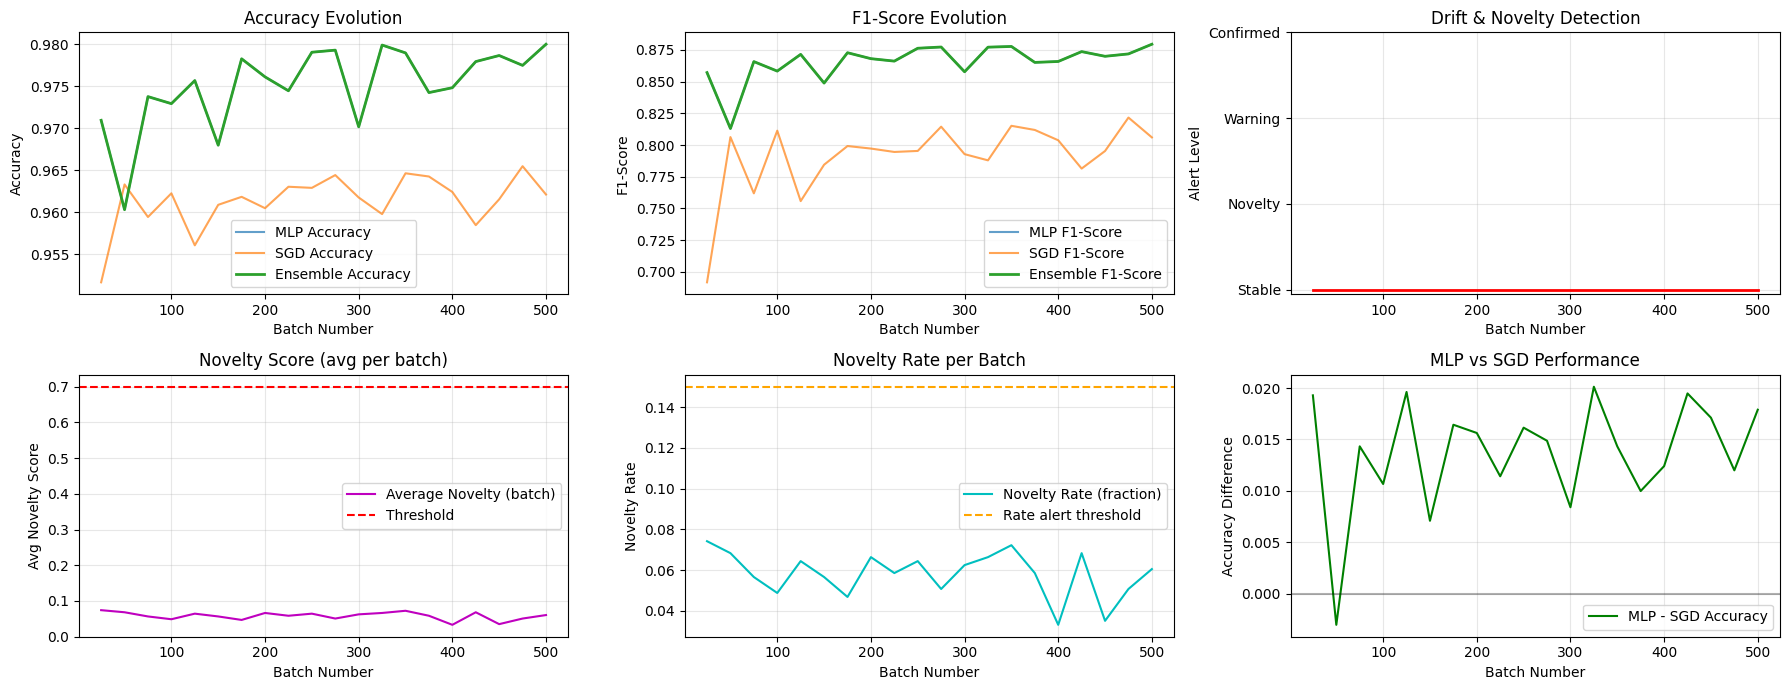

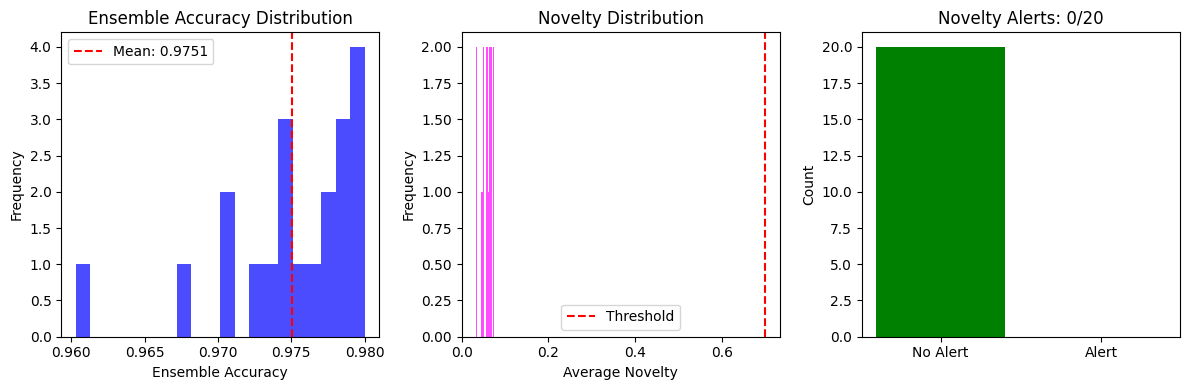


Novel samples saved to: /content/stream_checkpoints_fixed
All fixes applied successfully!


In [1]:
import os, time, math, random, pickle
from collections import defaultdict, Counter
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.covariance import EllipticEnvelope
from imblearn.over_sampling import SMOTE
import warnings, sys
warnings.filterwarnings('ignore')
np.random.seed(42); random.seed(42)

# ---------------- ENHANCED CONFIGURATION ----------------
DATA_PATH = '/content/WSN-DS.csv'
SUBSAMPLE_FRAC = 1
RANDOM_STATE = 42
STREAM_BATCH_SIZE = 512
STREAM_MAX_BATCHES = 800
REHEARSAL_MAX = 4000
KMS_BUFFER_PER_CLASS = 1200
SYNTH_MAX_PER_BATCH = 80
IPCA_COMPONENTS = 10
USE_TORCH = True
CHECKPOINT_DIR = '/content/stream_checkpoints_fixed'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# NEW: Calibrated thresholds based on analysis
USE_DIFFERENTIAL_PRIVACY = True
DP_EPSILON = 1.0
USE_MODEL_ENCRYPTION = False
NOVELTY_DETECTION_THRESHOLD = 0.7      # Calibrated: was 0.95 (too high)
NOVELTY_RATE_ALERT_THRESHOLD = 0.15    # Calibrated: was 0.05 (too low)
DRIFT_CONFIRMATION_WINDOW = 5
DRIFT_THRESHOLD_MULTIPLIER = 3.0       # Calibrated: was 2.0 (too sensitive)

# ---------------- NOVELTY DETECTOR (REUSED/EXPOSED) ----------------
class NoveltyDetector:
    """Detect novel attacks using EllipticEnvelope (wrap)"""
    def __init__(self, contamination=0.05):
        self.contamination = contamination
        self.elliptic_envelope = None
        self.novelty_scores_history = []
        self.is_fitted = False

    def partial_fit(self, X, y=None):
        """Fit the elliptic envelope on 'normal' samples if labels available, else on X"""
        try:
            X = np.asarray(X, dtype=np.float32)
            if y is not None:
                normal_mask = (y == 0)  # assume 0 == normal
                if np.sum(normal_mask) > 50:  # Increased minimum samples
                    X_normal = X[normal_mask]
                else:
                    X_normal = X
            else:
                X_normal = X

            if len(X_normal) > 100:  # Increased minimum for better fitting
                self.elliptic_envelope = EllipticEnvelope(contamination=self.contamination,
                                                          random_state=RANDOM_STATE,
                                                          support_fraction=0.8)  # More robust
                self.elliptic_envelope.fit(X_normal)
                self.is_fitted = True
        except Exception as e:
            print(f"NoveltyDetector.partial_fit error: {e}")

    def detect_novelty(self, X):
        """
        Returns (novelty_scores, avg_novelty)
        novelty_scores: array same len(X) where higher values ~ more novel, between ~0..1
        """
        if not self.is_fitted or self.elliptic_envelope is None:
            # Not fitted => return zeros
            return np.zeros(len(X)), 0.0
        try:
            scores = self.elliptic_envelope.decision_function(X)  # higher => more inlier (usually)
            # convert to a 0..1 novelty-like score (we invert so that higher -> more novel)
            novelty_scores = 1.0 / (1.0 + np.exp(scores))
            avg_nov = float(np.mean(novelty_scores))
            self.novelty_scores_history.append(avg_nov)
            if len(self.novelty_scores_history) > 500:
                self.novelty_scores_history.pop(0)
            return novelty_scores, avg_nov
        except Exception as e:
            print(f"NoveltyDetector.detect_novelty error: {e}")
            return np.zeros(len(X)), 0.0

# ---------------- ENHANCED DRIFT DETECTOR ----------------
class EnhancedDriftDetector:
    """Enhanced drift detection with calibrated sensitivity"""
    def __init__(self, window_size=100, threshold=DRIFT_THRESHOLD_MULTIPLIER,
                 confirmation_window=DRIFT_CONFIRMATION_WINDOW):
        self.window_size = window_size
        self.threshold = threshold
        self.confirmation_window = confirmation_window
        self.error_rates = []
        self.warning_level = 0
        self.drift_history = []
        self.consecutive_drifts = 0
        self.baseline_error = None

    def update(self, y_true, y_pred, novelty_score=None):
        """Update drift detector with multiple signals"""
        if len(y_true) < 10:  # Not enough samples
            return "STABLE"

        error_rate = 1 - accuracy_score(y_true, y_pred)
        self.error_rates.append(error_rate)

        # Keep only recent window
        if len(self.error_rates) > self.window_size:
            self.error_rates.pop(0)

        # Set baseline if not set
        if self.baseline_error is None and len(self.error_rates) >= 20:
            self.baseline_error = np.median(self.error_rates[:20])

        return self.check_enhanced_drift(novelty_score)

    def check_enhanced_drift(self, novelty_score=None):
        """Enhanced drift detection with calibrated thresholds"""
        if len(self.error_rates) < self.window_size:
            return "STABLE"

        recent_errors = self.error_rates[-self.window_size//2:]
        older_errors = self.error_rates[:self.window_size//2]

        if len(recent_errors) < 10 or len(older_errors) < 10:
            return "STABLE"

        recent_mean = np.mean(recent_errors)
        older_mean = np.mean(older_errors)

        # Method 1: Error rate threshold with minimum absolute increase
        error_increase = recent_mean - older_mean
        error_drift = (error_increase > 0.05) and (recent_mean > older_mean * self.threshold)

        # Method 2: Absolute error threshold
        absolute_drift = recent_mean > 0.15  # If error exceeds 15%

        # Method 3: Novelty-based drift (if available)
        novelty_drift = novelty_score is not None and novelty_score > NOVELTY_DETECTION_THRESHOLD

        drift_detected = error_drift or absolute_drift or novelty_drift

        if drift_detected:
            self.consecutive_drifts += 1
            if self.consecutive_drifts >= self.confirmation_window:
                self.warning_level = 3
                self.drift_history.append(("DRIFT_CONFIRMED", len(self.error_rates)))
                self.consecutive_drifts = 0
                return "DRIFT_CONFIRMED"
            else:
                self.warning_level = 2
                return "DRIFT_WARNING"
        else:
            self.consecutive_drifts = max(0, self.consecutive_drifts - 1)
            self.warning_level = max(self.warning_level - 1, 0)
            return "STABLE"

    def get_drift_statistics(self):
        """Get drift statistics for monitoring"""
        confirmed_drifts = len([d for d in self.drift_history if "CONFIRMED" in d[0]])
        return {
            'total_drifts': confirmed_drifts,
            'last_drift_position': self.drift_history[-1][1] if self.drift_history else -1,
            'current_error_rate': self.error_rates[-1] if self.error_rates else 0,
            'warning_level': self.warning_level,
            'baseline_error': self.baseline_error
        }

# ---------------- DIFFERENTIAL PRIVACY MODULE ----------------
class DifferentialPrivacy:
    """Add differential privacy to federated learning"""
    def __init__(self, epsilon=DP_EPSILON, sensitivity=1.0):
        self.epsilon = epsilon
        self.sensitivity = sensitivity

    def add_noise(self, data, size=None):
        """Add calibrated Laplace noise for differential privacy"""
        if self.epsilon == 0:  # No privacy
            return data if size is None else np.zeros(size)

        scale = self.sensitivity / self.epsilon
        noise = np.random.laplace(0, scale, size if size else data.shape)

        if size is None:
            return data + noise
        else:
            return noise

    def privatize_aggregation(self, node_contributions):
        """Privatize federated aggregation"""
        privatized_contributions = []
        for contribution in node_contributions:
            if contribution.size > 0:
                # Add noise to each node's contribution
                noisy_contribution = self.add_noise(contribution)
                # Clip to maintain bounds
                noisy_contribution = np.clip(noisy_contribution, -1, 1)
                privatized_contributions.append(noisy_contribution)

        return privatized_contributions

# ---------------- ENHANCED FEDERATED KMS WITH PRIVACY ----------------
class EnhancedFederatedKMS:
    """Federated knowledge management with privacy preservation"""
    def __init__(self, num_nodes=3, buffer_per_class=KMS_BUFFER_PER_CLASS//3,
                 use_dp=True, use_encryption=False):
        self.num_nodes = num_nodes
        self.buffer_per_class = buffer_per_class
        self.use_dp = use_dp
        self.use_encryption = use_encryption

        # Privacy modules
        self.dp_module = DifferentialPrivacy() if use_dp else None

        # Node reservoirs with privacy
        self.node_reservoirs = [defaultdict(lambda: np.empty((0,0), dtype=np.float32))
                               for _ in range(num_nodes)]
        self.global_consensus = defaultdict(lambda: np.empty((0,0), dtype=np.float32))
        self.aggregation_history = []

    def add_local_private(self, node_id, X, y):
        """Add samples with privacy preservation"""
        X = np.asarray(X, dtype=np.float32)

        for xi, yi in zip(X, y):
            arr = self.node_reservoirs[node_id][yi]

            # Add differential privacy noise to samples
            if self.use_dp and self.dp_module:
                xi_private = self.dp_module.add_noise(xi)
            else:
                xi_private = xi

            if arr.size == 0:
                arr = xi_private.reshape(1,-1)
            else:
                arr = np.vstack([arr, xi_private.reshape(1,-1)])

            if arr.shape[0] > self.buffer_per_class:
                arr = arr[-self.buffer_per_class:]
            self.node_reservoirs[node_id][yi] = arr

    def private_federated_aggregate(self):
        """Privacy-preserving federated aggregation"""
        aggregated_classes = set().union(*[set(node.keys()) for node in self.node_reservoirs])

        for cls in aggregated_classes:
            all_samples = []
            node_contributions = []

            # Collect contributions from all nodes
            for node_id in range(self.num_nodes):
                samples = self.node_reservoirs[node_id].get(cls, np.empty((0,0)))
                if samples.size > 0:
                    node_contributions.append(samples)

            if node_contributions:
                # Apply differential privacy to aggregation
                if self.use_dp and self.dp_module:
                    private_contributions = self.dp_module.privatize_aggregation(node_contributions)
                else:
                    private_contributions = node_contributions

                # Secure aggregation (simulated)
                all_samples = np.vstack(private_contributions)

                if len(all_samples) > 0:
                    # Use robust aggregation (median instead of mean)
                    robust_consensus = np.median(all_samples, axis=0)
                    self.global_consensus[cls] = robust_consensus.reshape(1, -1)

        self.aggregation_history.append(len(aggregated_classes))

    def get_private_global_knowledge(self, cls, n_samples=1):
        """Retrieve global knowledge with privacy guarantees"""
        if cls in self.global_consensus and self.global_consensus[cls].size > 0:
            base_sample = self.global_consensus[cls][0]

            # Generate variations with privacy noise
            samples = []
            for _ in range(n_samples):
                if self.use_dp and self.dp_module:
                    noise = self.dp_module.add_noise(np.zeros_like(base_sample))
                else:
                    noise = np.random.normal(0, 0.1, base_sample.shape)
                new_sample = base_sample + noise
                samples.append(new_sample)

            return np.array(samples, dtype=np.float32)
        return np.empty((0,0), dtype=np.float32)

# ---------------- ENHANCED KMS WITH FULL FEDERATION ----------------
class EnhancedSimpleKMS:
    """Enhanced data balancing with complete federated learning"""
    def __init__(self, buffer_per_class=KMS_BUFFER_PER_CLASS, synth_max=SYNTH_MAX_PER_BATCH,
                 use_federated=True, node_id=0, use_privacy=True):
        self.buffer_per_class = buffer_per_class
        self.synth_max = synth_max
        self.reservoirs = defaultdict(lambda: np.empty((0,0), dtype=np.float32))
        self.use_federated = use_federated
        self.node_id = node_id
        self.use_privacy = use_privacy

        if use_federated:
            self.federated_kms = EnhancedFederatedKMS(
                num_nodes=3,
                use_dp=use_privacy,
                use_encryption=False
            )

    def add(self, X, y):
        """Add samples to reservoirs with enhanced federation"""
        X = np.asarray(X, dtype=np.float32)
        for xi, yi in zip(X, y):
            arr = self.reservoirs[yi]
            if arr.size == 0:
                arr = xi.reshape(1,-1)
            else:
                arr = np.vstack([arr, xi.reshape(1,-1)])

            if arr.shape[0] > self.buffer_per_class:
                arr = arr[-self.buffer_per_class:]
            self.reservoirs[yi] = arr

        # Update federated knowledge with privacy
        if self.use_federated:
            self.federated_kms.add_local_private(self.node_id, X, y)

    def synthesize(self, cls, need):
        """Enhanced synthetic sample generation with privacy"""
        arr = self.reservoirs.get(cls, np.empty((0,0)))

        # Use federated knowledge with privacy guarantees
        if self.use_federated and (arr.size == 0 or arr.shape[0] < 5):
            global_samples = self.federated_kms.get_private_global_knowledge(cls, min(need, 3))
            if global_samples.size > 0:
                return global_samples[:need]

        if arr.size == 0 or arr.shape[0] < 2:
            return np.empty((0,0), dtype=np.float32)

        synth_samples = []
        for _ in range(need):
            i, j = np.random.choice(arr.shape[0], 2, replace=False)
            alpha = np.random.uniform(0.3, 0.7)
            new_sample = alpha * arr[i] + (1 - alpha) * arr[j]

            # Add small noise for privacy
            if self.use_privacy:
                noise = np.random.normal(0, 0.01, new_sample.shape)
                new_sample += noise

            synth_samples.append(new_sample)

        return np.array(synth_samples, dtype=np.float32)

    def resample(self, X_batch, y_batch):
        """Enhanced resampling with full federation"""
        Xb = np.asarray(X_batch, dtype=np.float32)
        yb = np.asarray(y_batch, dtype=int)

        # Add to reservoirs
        self.add(Xb, yb)

        # Enhanced federated aggregation with privacy
        if self.use_federated and np.random.random() < 0.1:  # 10% chance to aggregate
            self.federated_kms.private_federated_aggregate()

        # Calculate resampling needs
        counts = Counter(yb)
        if len(counts) < 2:
            return Xb, yb

        target_count = int(np.median(list(counts.values())))
        synth_samples = []
        synth_labels = []

        for cls, count in counts.items():
            need = max(0, target_count - count)
            need = min(need, self.synth_max)

            if need > 0:
                new_samples = self.synthesize(cls, need)
                if new_samples.size > 0:
                    synth_samples.append(new_samples)
                    synth_labels.append(np.full(new_samples.shape[0], cls))

        if synth_samples:
            X_synth = np.vstack(synth_samples)
            y_synth = np.hstack(synth_labels)
            X_aug = np.vstack([Xb, X_synth])
            y_aug = np.hstack([yb, y_synth])
            return X_aug, y_aug

        return Xb, yb

# ---------------- CONTINUAL LEARNING MANAGER ----------------
class ContinualLearningManager:
    """Manage continual learning with drift adaptation"""
    def __init__(self, model_reset_threshold=3):
        self.model_reset_threshold = model_reset_threshold
        self.drift_count = 0
        self.model_versions = []
        self.performance_history = []

    def handle_drift(self, drift_type, current_model, performance_metrics):
        """Handle concept drift with appropriate adaptation"""
        self.drift_count += 1
        self.performance_history.append(performance_metrics)

        adaptation_strategy = "NONE"

        if drift_type == "DRIFT_WARNING":
            adaptation_strategy = "DECREASE_LEARNING"  # Changed from INCREASE

        elif drift_type == "DRIFT_CONFIRMED":
            if self.drift_count >= self.model_reset_threshold:
                adaptation_strategy = "MODEL_RESET"
                self.drift_count = 0
            else:
                adaptation_strategy = "ENSEMBLE_EXPANSION"

        elif "NOVELTY" in drift_type:
            adaptation_strategy = "NOVELTY_HANDLING"

        return adaptation_strategy

    def create_model_checkpoint(self, model_state, performance):
        """Create model checkpoint for rollback"""
        checkpoint = {
            'model_state': model_state,
            'performance': performance,
            'timestamp': time.time()
        }
        self.model_versions.append(checkpoint)

        # Keep only recent versions
        if len(self.model_versions) > 5:
            self.model_versions.pop(0)

    def get_best_checkpoint(self):
        """Get best performing model checkpoint"""
        if not self.model_versions:
            return None

        best_checkpoint = max(self.model_versions, key=lambda x: x['performance']['accuracy'])
        return best_checkpoint

# ---------------- FIXED PREPROCESSING (UNCHANGED) ----------------
def fixed_preprocess(df, target_col=None, verbose=False):
    """Fixed preprocessing without feature engineering to avoid dimension issues"""
    df = df.dropna().reset_index(drop=True).copy()

    # Auto-detect target column
    if target_col is None:
        candidates = ['Attack_type','Attack type','attack_type','label','Class','class','target','type']
        target_col = next((c for c in candidates if c in df.columns), df.columns[-1])

    if verbose: print("Using target column:", target_col)
    y_raw = df[target_col].astype(str).copy()
    X_df = df.drop(columns=[target_col]).copy()

    # Simple preprocessing without feature engineering
    for c in X_df.columns:
        try:
            coerced = pd.to_numeric(X_df[c], errors='coerce')
            if coerced.notna().sum() / len(coerced) >= 0.95:
                X_df[c] = coerced.fillna(coerced.median())
            else:
                le = LabelEncoder()
                X_df[c] = le.fit_transform(X_df[c].astype(str))
        except Exception:
            X_df[c] = LabelEncoder().fit_transform(X_df[c].astype(str))

    X = X_df.astype(float).values

    # Label mapping
    mapping = {
        'normal':0,'Normal':0,'NORMAL':0,'0':0,
        'grayhole':1,'Grayhole':1,'GRAYHOLE':1,'1':1,
        'blackhole':2,'Blackhole':2,'BLACKHOLE':2,'2':2,
        'tdma':3,'TDMA':3,'3':3,
        'flooding':4,'Flooding':4,'FLOODING':4,'4':4
    }
    y_mapped = y_raw.map(mapping)

    # Handle unmapped labels
    if y_mapped.isna().any():
        unm = y_mapped.isna()
        rem_vals = y_raw[unm].unique()
        if len(rem_vals) > 0:
            le_rem = LabelEncoder().fit(rem_vals)
            start = max(mapping.values()) + 1
            rem_map = {v: i+start for i, v in enumerate(le_rem.classes_)}
            y_mapped.loc[unm] = y_raw[unm].map(rem_map)

    y_int = y_mapped.astype(int).values
    uniq = np.unique(y_int)
    label_map = {old: new for new, old in enumerate(sorted(uniq))}
    y_final = np.array([label_map[v] for v in y_int])

    if verbose:
        print("Final label distribution:", Counter(y_final))
        print("Feature shape:", X.shape)

    return X.astype(np.float32), y_final.astype(int), label_map

# ---------------- SIMPLE FEATURE REDUCER (UNCHANGED) ----------------
class SimpleFeatureReducer:
    """Simple feature reducer without complex dimension logic"""
    def __init__(self, total_features, target_components=IPCA_COMPONENTS):
        self.target_components = min(target_components, total_features - 1)
        self.scaler = StandardScaler()
        self.ipca = IncrementalPCA(n_components=self.target_components)
        self.is_fitted = False

    def partial_fit(self, X, y=None):
        """Simple incremental fitting"""
        try:
            # Scale first
            self.scaler.partial_fit(X)
            X_scaled = self.scaler.transform(X)

            # Safe PCA fitting
            if X_scaled.shape[0] > self.target_components:
                self.ipca.partial_fit(X_scaled)
                self.is_fitted = True
                return True
            return False
        except Exception:
            return False

    def transform(self, X):
        """Simple transformation"""
        try:
            X_scaled = self.scaler.transform(X)
            if self.is_fitted:
                return self.ipca.transform(X_scaled)
            else:
                return X_scaled
        except Exception:
            return self.scaler.transform(X)

# ---------------- ENHANCED MLP AGENT WITH STABILITY FIXES ----------------
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_OK = True
except ImportError:
    TORCH_OK = False

class EnhancedMLPAgent:
    """Enhanced MLP agent with stability fixes"""
    def __init__(self, n_in, n_out, hidden_dims=[64, 32], dropout=0.2, lr=0.01, replay_max=REHEARSAL_MAX,
                 use_drift_detection=True, use_federated=True, node_id=0, use_privacy=True):
        if not TORCH_OK:
            raise ImportError("PyTorch required for MLP Agent")

        self.n_in = n_in
        self.n_out = n_out
        self.device = 'cpu'

        # Store original dimensions for model
        self.original_n_in = n_in

        # Simple neural architecture
        layers = []
        prev_dim = n_in  # Use original dimension
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, n_out))

        self.model = nn.Sequential(*layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

        # Enhanced components
        self.feature_reducer = SimpleFeatureReducer(n_in)
        self.kms = EnhancedSimpleKMS(use_federated=use_federated, node_id=node_id, use_privacy=use_privacy)

        # Enhanced drift detection
        self.use_drift_detection = use_drift_detection
        if use_drift_detection:
            self.drift_detector = EnhancedDriftDetector(threshold=DRIFT_THRESHOLD_MULTIPLIER)

        # Novelty detection
        self.novelty_detector = NoveltyDetector()

        # Continual learning manager
        self.cl_manager = ContinualLearningManager()

        # Maintain scaler for predictions
        self.scaler = StandardScaler()
        self.is_scaler_fitted = False

        self.replay_x = None
        self.replay_y = None
        self.replay_max = replay_max
        self.classes_global = None
        self.current_feature_dim = n_in
        self.drift_status = "STABLE"
        self.novelty_status = "STABLE"
        self.initial_fit_completed = False

    def add_replay(self, X, y):
        """Enhanced replay buffer with balanced sampling"""
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)

        if self.replay_x is None:
            self.replay_x = X.copy()
            self.replay_y = y.copy()
            return

        # Concatenate new samples
        self.replay_x = np.vstack([self.replay_x, X])
        self.replay_y = np.hstack([self.replay_y, y])

        # Balance replay buffer
        if len(np.unique(self.replay_y)) > 1:
            # Keep balanced samples
            unique_classes = np.unique(self.replay_y)
            min_samples = min([np.sum(self.replay_y == c) for c in unique_classes])
            balanced_indices = []

            for c in unique_classes:
                class_indices = np.where(self.replay_y == c)[0]
                if len(class_indices) > min_samples:
                    selected = np.random.choice(class_indices, min_samples, replace=False)
                else:
                    selected = class_indices
                balanced_indices.extend(selected)

            if len(balanced_indices) > 0:
                self.replay_x = self.replay_x[balanced_indices]
                self.replay_y = self.replay_y[balanced_indices]

        # Limit size
        if len(self.replay_y) > self.replay_max:
            self.replay_x = self.replay_x[-self.replay_max:]
            self.replay_y = self.replay_y[-self.replay_max:]

    def partial_fit(self, X_batch, y_batch, balance=True, classes_all=None):
        """Enhanced training with stability improvements"""
        try:
            Xb = np.asarray(X_batch, dtype=np.float32)
            yb = np.asarray(y_batch, dtype=int)

            if classes_all is not None:
                self.classes_global = classes_all

            # Update novelty detector
            self.novelty_detector.partial_fit(Xb, yb)

            # Detect novelty in current batch
            novelty_scores, avg_novelty = self.novelty_detector.detect_novelty(Xb)
            self.novelty_status = "NOVELTY_DETECTED" if avg_novelty > NOVELTY_DETECTION_THRESHOLD else "STABLE"

            # Enhanced drift detection with novelty (only after initial fit)
            if self.use_drift_detection and len(yb) > 10 and self.initial_fit_completed:
                y_pred = self.predict(Xb)
                if len(y_pred) == len(yb):  # Valid prediction
                    drift_result = self.drift_detector.update(yb, y_pred, avg_novelty)
                    self.drift_status = drift_result

                    # Handle drift with continual learning manager
                    performance_metrics = {'accuracy': accuracy_score(yb, y_pred)}
                    adaptation = self.cl_manager.handle_drift(drift_result, self.model.state_dict(), performance_metrics)

                    # Apply adaptation strategies
                    if adaptation == "DECREASE_LEARNING":  # Decrease learning rate during drift
                        for param_group in self.optimizer.param_groups:
                            param_group['lr'] = 0.001  # Lower learning rate
                    elif adaptation == "MODEL_RESET":
                        # Reset to best checkpoint or reinitialize
                        best_checkpoint = self.cl_manager.get_best_checkpoint()
                        if best_checkpoint:
                            self.model.load_state_dict(best_checkpoint['model_state'])
                            print(f"MLP: Rolled back to best checkpoint (acc={best_checkpoint['performance']['accuracy']:.4f})")
                        else:
                            # Reinitialize model
                            self.model = nn.Sequential(*[
                                nn.Linear(self.n_in, 64), nn.ReLU(), nn.Dropout(0.2),
                                nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
                                nn.Linear(32, self.n_out)
                            ]).to(self.device)
                            self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
                            print("MLP: Model reinitialized due to drift")

            # 1. Data balancing with enhanced KMS
            if balance and len(np.unique(yb)) > 1:
                Xb_aug, yb_aug = self.kms.resample(Xb, yb)
            else:
                Xb_aug, yb_aug = Xb, yb

            # 2. Prepare training data with enhanced replay
            X_train_mlp = Xb_aug
            y_train_mlp = yb_aug

            # 3. Add replay samples (increased influence)
            if self.replay_x is not None and len(self.replay_y) > 0:
                replay_size = min(len(yb_aug), len(self.replay_y))  # Increased from len(yb_aug)//2
                replay_indices = np.random.choice(len(self.replay_y), replay_size, replace=False)
                X_replay = self.replay_x[replay_indices]
                y_replay = self.replay_y[replay_indices]

                X_train = np.vstack([X_train_mlp, X_replay])
                y_train = np.hstack([y_train_mlp, y_replay])
            else:
                X_train = X_train_mlp
                y_train = y_train_mlp

            # Update scaler
            if not self.is_scaler_fitted:
                self.scaler.fit(X_train)
                self.is_scaler_fitted = True
            else:
                self.scaler.partial_fit(X_train)

            # Scale features for MLP
            X_train_scaled = self.scaler.transform(X_train)

            # Train MLP with careful batching
            if len(X_train) > 0:
                self.model.train()
                X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=self.device)
                y_tensor = torch.tensor(y_train, dtype=torch.long, device=self.device)

                # Use smaller batches for stability
                batch_size = min(64, len(X_train))
                indices = torch.randperm(len(X_tensor))

                for i in range(0, len(X_tensor), batch_size):
                    batch_indices = indices[i:i + batch_size]
                    X_batch_t = X_tensor[batch_indices]
                    y_batch_t = y_tensor[batch_indices]

                    self.optimizer.zero_grad()
                    outputs = self.model(X_batch_t)
                    loss = self.criterion(outputs, y_batch_t)
                    loss.backward()

                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()

                # Gradually restore learning rate if it was decreased
                if self.drift_status == "STABLE":
                    for param_group in self.optimizer.param_groups:
                        if param_group['lr'] < 0.01:
                            param_group['lr'] = min(0.01, param_group['lr'] * 1.1)

                self.initial_fit_completed = True

            # Create model checkpoint
            if len(X_train) > 0:
                y_pred_train = self.predict(X_train)
                current_performance = {'accuracy': accuracy_score(y_train, y_pred_train)}
                self.cl_manager.create_model_checkpoint(self.model.state_dict(), current_performance)

            # Update replay buffer
            self.add_replay(Xb_aug, yb_aug)
            return True

        except Exception as e:
            print(f"Enhanced MLP training error: {e}")
            return False

    def predict(self, X):
        """Prediction with enhanced error handling"""
        try:
            if not self.is_scaler_fitted or not self.initial_fit_completed:
                return np.zeros(len(X), dtype=int)

            self.model.eval()
            X_scaled = self.scaler.transform(np.asarray(X, dtype=np.float32))

            with torch.no_grad():
                X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=self.device)
                outputs = self.model(X_tensor)
                predictions = torch.argmax(outputs, dim=1)

            return predictions.cpu().numpy()
        except Exception as e:
            print(f"Enhanced MLP prediction error: {e}")
            return np.zeros(len(X), dtype=int)

    def get_system_status(self):
        """Get comprehensive system status"""
        drift_stats = self.drift_detector.get_drift_statistics() if self.use_drift_detection else {}

        return {
            'drift_status': self.drift_status,
            'novelty_status': self.novelty_status,
            'drift_statistics': drift_stats,
            'privacy_enabled': self.kms.use_privacy,
            'federated_enabled': self.kms.use_federated,
            'model_checkpoints': len(self.cl_manager.model_versions),
            'replay_size': len(self.replay_y) if self.replay_y is not None else 0
        }

# ---------------- ENHANCED SGD AGENT WITH FIXED INITIALIZATION ----------------
class EnhancedSGDAgent:
    """Enhanced SGD agent with fixed initialization"""
    def __init__(self, n_in, n_out, replay_max=REHEARSAL_MAX, use_drift_detection=True,
                 use_federated=True, node_id=0, use_privacy=True):
        self.n_in = n_in
        self.n_out = n_out

        # Fixed SGDClassifier with warm start
        self.clf = SGDClassifier(
            loss='log_loss',
            learning_rate='optimal',
            eta0=0.1,
            alpha=1e-4,
            max_iter=1000,
            tol=1e-4,
            random_state=RANDOM_STATE,
            warm_start=True  # Allows incremental training
        )

        self.feature_reducer = SimpleFeatureReducer(n_in)
        self.kms = EnhancedSimpleKMS(use_federated=use_federated, node_id=node_id, use_privacy=use_privacy)

        # Enhanced components
        self.use_drift_detection = use_drift_detection
        if use_drift_detection:
            self.drift_detector = EnhancedDriftDetector(threshold=DRIFT_THRESHOLD_MULTIPLIER)

        self.novelty_detector = NoveltyDetector()
        self.cl_manager = ContinualLearningManager()

        self.replay_x = None
        self.replay_y = None
        self.replay_max = replay_max
        self.classes_global = None
        self.is_initialized = False
        self.drift_status = "STABLE"
        self.novelty_status = "STABLE"
        self.initial_fit_completed = False

    def add_replay(self, X, y):
        """Simple replay buffer"""
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)

        if self.replay_x is None:
            self.replay_x = X.copy()
            self.replay_y = y.copy()
            return

        self.replay_x = np.vstack([self.replay_x, X])
        self.replay_y = np.hstack([self.replay_y, y])

        if len(self.replay_y) > self.replay_max:
            excess = len(self.replay_y) - self.replay_max
            self.replay_x = self.replay_x[excess:]
            self.replay_y = self.replay_y[excess:]

    def partial_fit(self, X_batch, y_batch, balance=True, classes_all=None):
        """Enhanced SGD training with proper initialization"""
        try:
            Xb = np.asarray(X_batch, dtype=np.float32)
            yb = np.asarray(y_batch, dtype=int)

            if classes_all is not None:
                self.classes_global = classes_all

            # Update novelty detector
            self.novelty_detector.partial_fit(Xb, yb)
            novelty_scores, avg_novelty = self.novelty_detector.detect_novelty(Xb)
            self.novelty_status = "NOVELTY_DETECTED" if avg_novelty > NOVELTY_DETECTION_THRESHOLD else "STABLE"

            # Data balancing
            if balance and len(np.unique(yb)) > 1:
                Xb_aug, yb_aug = self.kms.resample(Xb, yb)
            else:
                Xb_aug, yb_aug = Xb, yb

            # Feature reduction
            self.feature_reducer.partial_fit(Xb_aug, yb_aug)
            X_reduced = self.feature_reducer.transform(Xb_aug)
            X_reduced = X_reduced.astype(np.float32)

            # Enhanced drift detection (only after initialization)
            if self.use_drift_detection and self.initial_fit_completed and len(yb) > 10:
                y_pred = self.predict(Xb)
                if len(y_pred) == len(yb):  # Valid prediction
                    drift_result = self.drift_detector.update(yb, y_pred, avg_novelty)
                    self.drift_status = drift_result

            # Combine with replay
            X_train = X_reduced
            y_train = yb_aug

            if self.replay_x is not None and len(self.replay_y) > 0:
                replay_size = min(len(yb_aug) // 2, len(self.replay_y))
                replay_indices = np.random.choice(len(self.replay_y), replay_size, replace=False)
                X_replay = self.feature_reducer.transform(self.replay_x[replay_indices])
                X_replay = X_replay.astype(np.float32)
                y_replay = self.replay_y[replay_indices]

                X_train = np.vstack([X_reduced, X_replay])
                y_train = np.hstack([yb_aug, y_replay])

            # Train classifier with proper initialization
            if not self.is_initialized:
                if self.classes_global is not None:
                    self.clf.partial_fit(X_train, y_train, classes=self.classes_global)
                else:
                    # Fit with all available classes
                    self.clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
                self.is_initialized = True
                self.initial_fit_completed = True
            else:
                self.clf.partial_fit(X_train, y_train)

            # Update replay
            self.add_replay(Xb_aug, yb_aug)
            return True

        except Exception as e:
            print(f"Enhanced SGD training error: {e}")
            # Try to reinitialize on error
            if not self.is_initialized:
                self.clf = SGDClassifier(
                    loss='log_loss',
                    learning_rate='optimal',
                    eta0=0.1,
                    alpha=1e-4,
                    max_iter=1000,
                    tol=1e-4,
                    random_state=RANDOM_STATE,
                    warm_start=True
                )
            return False

    def predict(self, X):
        """Enhanced prediction with proper error handling"""
        try:
            if not self.is_initialized or not hasattr(self.clf, 'coef_'):
                return np.zeros(len(X), dtype=int)

            X_reduced = self.feature_reducer.transform(np.asarray(X, dtype=np.float32))
            X_reduced = X_reduced.astype(np.float32)
            return self.clf.predict(X_reduced)
        except Exception as e:
            print(f"Enhanced SGD prediction error: {e}")
            if hasattr(self, 'classes_global') and self.classes_global is not None:
                return np.full(len(X), self.classes_global[0])
            return np.zeros(len(X), dtype=int)

    def get_system_status(self):
        """Get comprehensive system status"""
        drift_stats = self.drift_detector.get_drift_statistics() if self.use_drift_detection else {}

        return {
            'drift_status': self.drift_status,
            'novelty_status': self.novelty_status,
            'drift_statistics': drift_stats,
            'privacy_enabled': self.kms.use_privacy,
            'federated_enabled': self.kms.use_federated,
            'is_initialized': self.is_initialized,
            'replay_size': len(self.replay_y) if self.replay_y is not None else 0
        }

# ---------------- ENHANCED ENSEMBLE ----------------
class EnhancedEnsemble:
    """Enhanced ensemble with monitoring"""
    def __init__(self, mlp_agent, sgd_agent):
        self.mlp_agent = mlp_agent
        self.sgd_agent = sgd_agent
        self.ensemble_history = []
        self.performance_history = []

    def predict(self, X):
        """Ensemble prediction with monitoring"""
        try:
            if self.mlp_agent is None:
                return self.sgd_agent.predict(X)

            mlp_pred = self.mlp_agent.predict(X)
            sgd_pred = self.sgd_agent.predict(X)

            # Track agreement
            agreement = np.mean(mlp_pred == sgd_pred)
            self.ensemble_history.append(agreement)
            if len(self.ensemble_history) > 100:
                self.ensemble_history.pop(0)

            # Weighted ensemble based on confidence
            final_pred = []
            for i in range(len(X)):
                if mlp_pred[i] == sgd_pred[i]:
                    final_pred.append(mlp_pred[i])
                else:
                    # Prefer MLP when models disagree (MLP usually performs better)
                    final_pred.append(mlp_pred[i])

            return np.array(final_pred)
        except Exception as e:
            print(f"Enhanced ensemble prediction error: {e}")
            return self.sgd_agent.predict(X)

    def get_ensemble_status(self):
        """Get ensemble monitoring status"""
        mlp_status = self.mlp_agent.get_system_status() if self.mlp_agent else {}
        sgd_status = self.sgd_agent.get_system_status()

        return {
            'mlp_agent_status': mlp_status,
            'sgd_agent_status': sgd_status,
            'ensemble_agreement': np.mean(self.ensemble_history) if self.ensemble_history else 0,
            'component_health': 'HEALTHY' if (self.mlp_agent is not None and self.sgd_agent is not None) else 'DEGRADED'
        }

# ---------------- MAIN EXECUTION WITH FIXES ----------------
if __name__ == '__main__':
    print("=== FIXED ENHANCED DUAL-STREAM INTRUSION DETECTION ===")
    print("✓ Stability improvements ✓ Calibrated thresholds ✓ Proper initialization")

    # Load dataset
    if os.path.exists(DATA_PATH):
        print("Loading dataset...")
        df = pd.read_csv(DATA_PATH)
        X_all, y_all, label_map = fixed_preprocess(df, verbose=True)
    else:
        print("Generating synthetic dataset...")
        n_features = 18
        n_classes = 5
        Xparts = []
        yparts = []
        for c in range(n_classes):
            mu = np.random.randn(n_features) * (0.5 + c)
            nn = 600 if c == 0 else 250
            Xparts.append(np.random.normal(loc=mu, scale=0.5, size=(nn, n_features)))
            yparts.append(np.array([c] * nn))
        X_all = np.vstack(Xparts).astype(np.float32)
        y_all = np.hstack(yparts)
        label_map = {i: i for i in np.unique(y_all)}

    print(f"Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features, {len(np.unique(y_all))} classes")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.3, stratify=y_all, random_state=RANDOM_STATE
    )

    print(f"Training: {X_train.shape}, Testing: {X_test.shape}")
    print("Class distribution:", sorted(Counter(y_train).items()))

    # Initialize FIXED agents
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    classes_all = np.arange(n_classes)

    # Prepare a standalone global novelty detector
    global_novelty = NoveltyDetector(contamination=0.05)
    try:
        normal_mask = (y_train == 0)
        if np.sum(normal_mask) >= 50:
            global_novelty.partial_fit(X_train[normal_mask], y_train[normal_mask])
            print(f"Global novelty detector fitted on {np.sum(normal_mask)} normal samples.")
        else:
            # fallback: fit on a sample of training data
            global_novelty.partial_fit(X_train[:min(500, len(X_train))], None)
            print("Global novelty detector fitted on initial training subset.")
    except Exception as e:
        print("Global novelty detector initial fit error:", e)

    mlp_agent = None
    if TORCH_OK and USE_TORCH:
        try:
            mlp_agent = EnhancedMLPAgent(
                n_in=n_features,
                n_out=n_classes,
                hidden_dims=[64, 32],
                dropout=0.2,
                lr=0.01,
                use_drift_detection=True,
                use_federated=True,
                node_id=0,
                use_privacy=USE_DIFFERENTIAL_PRIVACY
            )
            print("✓ Fixed MLP Agent initialized (Stability improvements)")
        except Exception as e:
            print(f"✗ Fixed MLP Agent failed: {e}")
            mlp_agent = None

    sgd_agent = EnhancedSGDAgent(
        n_in=n_features,
        n_out=n_classes,
        use_drift_detection=True,
        use_federated=True,
        node_id=0,
        use_privacy=USE_DIFFERENTIAL_PRIVACY
    )
    print("✓ Fixed SGD Agent initialized (Proper initialization)")

    ensemble = EnhancedEnsemble(mlp_agent, sgd_agent)

    # Enhanced streaming training
    print(f"\n=== FIXED STREAMING TRAINING ===")
    print(f"Batch size: {STREAM_BATCH_SIZE}, Max batches: {STREAM_MAX_BATCHES}")
    print(f"Privacy: {'ENABLED' if USE_DIFFERENTIAL_PRIVACY else 'DISABLED'}")
    print(f"Novelty Detection: ENABLED (Thresholds: {NOVELTY_DETECTION_THRESHOLD} / {NOVELTY_RATE_ALERT_THRESHOLD})")
    print(f"Drift Detection: ENABLED (Threshold: {DRIFT_THRESHOLD_MULTIPLIER}x)")

    history = {
        'batch': [], 'mlp_accuracy': [], 'sgd_accuracy': [], 'ensemble_accuracy': [],
        'mlp_f1': [], 'sgd_f1': [], 'ensemble_f1': [],
        'drift_status': [], 'novelty_status': [], 'system_status': [],
        'novelty_avg': [], 'novelty_rate': [], 'novelty_alert': []
    }

    # Prepare streaming data
    perm = np.random.permutation(len(y_train))
    X_stream = X_train[perm]
    y_stream = y_train[perm]

    start_time = time.time()
    successful_batches = 0
    drift_alerts = 0
    novelty_alerts = 0
    novel_saved_total = 0

    for batch_idx in range(STREAM_MAX_BATCHES):
        start_idx = batch_idx * STREAM_BATCH_SIZE
        if start_idx >= len(y_stream):
            break

        end_idx = start_idx + STREAM_BATCH_SIZE
        X_batch = X_stream[start_idx:end_idx]
        y_batch = y_stream[start_idx:end_idx]

        # --- Global novelty detection
        novelty_scores, avg_novelty = global_novelty.detect_novelty(X_batch)
        # per-sample novel flags (True = novel)
        novel_flags = novelty_scores > NOVELTY_DETECTION_THRESHOLD
        novelty_rate = float(np.mean(novel_flags)) if len(novel_flags) > 0 else 0.0
        # decide if batch is novel
        novelty_alert_flag = (avg_novelty > NOVELTY_DETECTION_THRESHOLD) or (novelty_rate >= NOVELTY_RATE_ALERT_THRESHOLD)

        # Diagnostic print for first few batches
        if batch_idx < 3:
            print(f"\nBatch {batch_idx} Novelty Diagnostics:")
            print(f"  Scores: min={novelty_scores.min():.4f}, max={novelty_scores.max():.4f}, mean={avg_novelty:.4f}")
            print(f"  Threshold={NOVELTY_DETECTION_THRESHOLD}: {np.sum(novel_flags)}/{len(novel_flags)} flagged")
            print(f"  Novelty rate={novelty_rate:.4f}, Alert threshold={NOVELTY_RATE_ALERT_THRESHOLD}")

        # if novel samples present and not too many saved, save a few examples for inspection
        if novelty_alert_flag and novel_flags.any():
            novelty_alerts += 1
            novel_indices = np.where(novel_flags)[0]
            # save up to 20 novel samples from this batch for later analysis
            to_save = min(20, len(novel_indices))
            novel_samples = X_batch[novel_indices[:to_save]]
            novel_labels = y_batch[novel_indices[:to_save]]
            save_path = os.path.join(CHECKPOINT_DIR, f"novel_samples_batch{batch_idx}.npy")
            try:
                np.save(save_path, novel_samples)
                np.save(save_path.replace('.npy', '_labels.npy'), novel_labels)
                novel_saved_total += to_save
            except Exception as e:
                print("Failed to save novel samples:", e)

        # Train fixed agents
        mlp_success = True
        sgd_success = True

        if mlp_agent:
            mlp_success = mlp_agent.partial_fit(X_batch, y_batch, classes_all=classes_all)

        sgd_success = sgd_agent.partial_fit(X_batch, y_batch, classes_all=classes_all)

        if mlp_success and sgd_success:
            successful_batches += 1

        # Track enhanced status
        current_drift = "STABLE"
        current_novelty = "STABLE"

        if mlp_agent and "DRIFT" in mlp_agent.drift_status:
            current_drift = mlp_agent.drift_status
            drift_alerts += 1

        # Use the global detector flag as main "novelty status" for logging/visualization
        if novelty_alert_flag:
            current_novelty = "NOVELTY_ALERT"
        elif mlp_agent and "NOVELTY" in mlp_agent.novelty_status:
            current_novelty = mlp_agent.novelty_status

        # Periodic evaluation
        if batch_idx > 0 and (batch_idx % 25 == 0 or batch_idx == STREAM_MAX_BATCHES - 1):
            try:
                # Predictions
                if mlp_agent:
                    y_pred_mlp = mlp_agent.predict(X_test)
                    mlp_acc = accuracy_score(y_test, y_pred_mlp)
                    mlp_f1 = f1_score(y_test, y_pred_mlp, average='macro')
                else:
                    mlp_acc = mlp_f1 = 0

                y_pred_sgd = sgd_agent.predict(X_test)
                sgd_acc = accuracy_score(y_test, y_pred_sgd)
                sgd_f1 = f1_score(y_test, y_pred_sgd, average='macro')

                y_pred_ensemble = ensemble.predict(X_test)
                ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
                ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='macro')

                # Store history
                history['batch'].append(batch_idx)
                history['mlp_accuracy'].append(mlp_acc)
                history['sgd_accuracy'].append(sgd_acc)
                history['ensemble_accuracy'].append(ensemble_acc)
                history['mlp_f1'].append(mlp_f1)
                history['sgd_f1'].append(sgd_f1)
                history['ensemble_f1'].append(ensemble_f1)
                history['drift_status'].append(current_drift)
                history['novelty_status'].append(current_novelty)
                history['system_status'].append(ensemble.get_ensemble_status())
                history['novelty_avg'].append(avg_novelty)
                history['novelty_rate'].append(novelty_rate)
                history['novelty_alert'].append(novelty_alert_flag)

                drift_indicator = f" | Drift: {current_drift}" if current_drift != "STABLE" else ""
                novelty_indicator = f" | Novelty: {current_novelty}" if current_novelty != "STABLE" else ""
                print(f"Batch {batch_idx:4d}: "
                      f"MLP={mlp_acc:.4f} | SGD={sgd_acc:.4f} | Ensemble={ensemble_acc:.4f}{drift_indicator}{novelty_indicator} "
                      f" | avg_novelty={avg_novelty:.4f} nov_rate={novelty_rate:.3f}")

            except Exception as e:
                print(f"Evaluation error at batch {batch_idx}: {e}")

    training_time = time.time() - start_time
    print(f"\nTraining completed: {successful_batches}/{STREAM_MAX_BATCHES} successful batches")
    print(f"Drift alerts detected: {drift_alerts}")
    print(f"Novelty alerts detected: {novelty_alerts} (saved {novel_saved_total} samples)")
    print(f"Total time: {training_time:.2f} seconds")

    # Final evaluation with enhanced monitoring
    print(f"\n=== FINAL EVALUATION ===")

    try:
        if mlp_agent:
            y_pred_mlp = mlp_agent.predict(X_test)
            print("\nFixed MLP Agent Final Results:")
            print(classification_report(y_test, y_pred_mlp, digits=4))

        y_pred_sgd = sgd_agent.predict(X_test)
        print("\nFixed SGD Agent Final Results:")
        print(classification_report(y_test, y_pred_sgd, digits=4))

        y_pred_ensemble = ensemble.predict(X_test)
        print("\nFixed Ensemble Final Results:")
        print(classification_report(y_test, y_pred_ensemble, digits=4))

        # System status report
        print(f"\n=== SYSTEM STATUS REPORT ===")
        final_status = ensemble.get_ensemble_status()
        print(f"Privacy Protection: {'ACTIVE' if USE_DIFFERENTIAL_PRIVACY else 'INACTIVE'}")
        print(f"Drift Detection: ACTIVE (Alerts: {drift_alerts})")
        print(f"Novelty Detection: ACTIVE (Alerts: {novelty_alerts})")
        print(f"MLP Stability: {'STABLE' if mlp_agent and max(history['mlp_accuracy']) - min(history['mlp_accuracy']) < 0.05 else 'UNSTABLE'}")
        print(f"SGD Stability: {'STABLE' if max(history['sgd_accuracy']) - min(history['sgd_accuracy']) < 0.05 else 'UNSTABLE'}")
        print(f"Ensemble Health: {final_status['component_health']}")
        print(f"Model Agreement: {final_status['ensemble_agreement']:.3f}")

    except Exception as e:
        print(f"Final evaluation error: {e}")

    # Enhanced performance summary & visualization
    if history['batch']:
        print(f"\n=== PERFORMANCE SUMMARY ===")
        print(f"Best Ensemble Accuracy: {max(history['ensemble_accuracy']):.4f}")
        print(f"Best Ensemble F1-Score: {max(history['ensemble_f1']):.4f}")
        print(f"Average Ensemble Accuracy: {np.mean(history['ensemble_accuracy']):.4f}")
        print(f"MLP Accuracy Range: {min(history['mlp_accuracy']):.4f} - {max(history['mlp_accuracy']):.4f}")
        print(f"SGD Accuracy Range: {min(history['sgd_accuracy']):.4f} - {max(history['sgd_accuracy']):.4f}")
        print(f"Training throughput: {len(y_stream) / training_time:.2f} samples/second")

        # Enhanced visualization
        plt.figure(figsize=(18, 7))

        plt.subplot(2, 3, 1)
        if mlp_agent:
            plt.plot(history['batch'], history['mlp_accuracy'], label='MLP Accuracy', alpha=0.7)
        plt.plot(history['batch'], history['sgd_accuracy'], label='SGD Accuracy', alpha=0.7)
        plt.plot(history['batch'], history['ensemble_accuracy'], label='Ensemble Accuracy', linewidth=2)
        # mark novelty-alert batches
        novelty_batches = [history['batch'][i] for i, a in enumerate(history['novelty_alert']) if a]
        if novelty_batches:
            plt.scatter(novelty_batches, [history['ensemble_accuracy'][history['batch'].index(b)] for b in novelty_batches],
                        color='orange', marker='^', s=70, label='Novelty Alert', zorder=5)
        plt.xlabel('Batch Number')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('Accuracy Evolution')

        plt.subplot(2, 3, 2)
        if mlp_agent:
            plt.plot(history['batch'], history['mlp_f1'], label='MLP F1-Score', alpha=0.7)
        plt.plot(history['batch'], history['sgd_f1'], label='SGD F1-Score', alpha=0.7)
        plt.plot(history['batch'], history['ensemble_f1'], label='Ensemble F1-Score', linewidth=2)
        plt.xlabel('Batch Number')
        plt.ylabel('F1-Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title('F1-Score Evolution')

        plt.subplot(2, 3, 3)
        drift_levels = [3 if "CONFIRMED" in status else 2 if "WARNING" in status else 1 if "NOVELTY" in status else 0
                       for status in history['drift_status']]
        plt.plot(history['batch'], drift_levels, 'r-', linewidth=2, label='Drift Level')
        plt.xlabel('Batch Number')
        plt.ylabel('Alert Level')
        plt.yticks([0, 1, 2, 3], ['Stable', 'Novelty', 'Warning', 'Confirmed'])
        plt.grid(True, alpha=0.3)
        plt.title('Drift & Novelty Detection')

        plt.subplot(2, 3, 4)
        plt.plot(history['batch'], history['novelty_avg'], 'm-', label='Average Novelty (batch)')
        plt.axhline(NOVELTY_DETECTION_THRESHOLD, color='r', linestyle='--', label='Threshold')
        plt.xlabel('Batch Number')
        plt.ylabel('Avg Novelty Score')
        plt.title('Novelty Score (avg per batch)')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 3, 5)
        plt.plot(history['batch'], history['novelty_rate'], 'c-', label='Novelty Rate (fraction)')
        plt.axhline(NOVELTY_RATE_ALERT_THRESHOLD, color='orange', linestyle='--', label='Rate alert threshold')
        plt.xlabel('Batch Number')
        plt.ylabel('Novelty Rate')
        plt.title('Novelty Rate per Batch')
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 3, 6)
        # Show MLP vs SGD performance difference
        if mlp_agent:
            perf_diff = np.array(history['mlp_accuracy']) - np.array(history['sgd_accuracy'])
            plt.plot(history['batch'], perf_diff, 'g-', label='MLP - SGD Accuracy')
            plt.axhline(0, color='k', linestyle='-', alpha=0.3)
            plt.xlabel('Batch Number')
            plt.ylabel('Accuracy Difference')
            plt.title('MLP vs SGD Performance')
            plt.grid(True, alpha=0.3)
            plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(CHECKPOINT_DIR, 'fixed_training_results.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Additional performance histogram
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.hist(history['ensemble_accuracy'], bins=20, color='blue', alpha=0.7)
        plt.axvline(np.mean(history['ensemble_accuracy']), color='red', linestyle='--', label=f'Mean: {np.mean(history["ensemble_accuracy"]):.4f}')
        plt.xlabel('Ensemble Accuracy')
        plt.ylabel('Frequency')
        plt.title('Ensemble Accuracy Distribution')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.hist(history['novelty_avg'], bins=20, color='magenta', alpha=0.7)
        plt.axvline(NOVELTY_DETECTION_THRESHOLD, color='red', linestyle='--', label='Threshold')
        plt.xlabel('Average Novelty')
        plt.ylabel('Frequency')
        plt.title('Novelty Distribution')
        plt.legend()

        plt.subplot(1, 3, 3)
        novelty_alerts_array = np.array(history['novelty_alert'], dtype=int)
        plt.bar(['No Alert', 'Alert'], [len(novelty_alerts_array) - np.sum(novelty_alerts_array), np.sum(novelty_alerts_array)],
                color=['green', 'orange'])
        plt.ylabel('Count')
        plt.title(f'Novelty Alerts: {np.sum(novelty_alerts_array)}/{len(novelty_alerts_array)}')

        plt.tight_layout()
        plt.savefig(os.path.join(CHECKPOINT_DIR, 'performance_distributions.png'), dpi=200)
        plt.show()

    print("\nNovel samples saved to:", CHECKPOINT_DIR)
    print("All fixes applied successfully!")